In [ ]:
!git clone https://github.com/elemannoni/SNR-based-Selective-Model-Merging.git
%cd SNR-based-Selective-Model-Merging

/home/simone/jupyter_files/SNR-based-Selective-Model-Merging


## Importazione librerie utili

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import time
import tracemalloc
from scipy.optimize import linear_sum_assignment
from copy import deepcopy
from sklearn.metrics import f1_score
import pandas as pd
from matplotlib.patches import Patch
import re

## Preparazione Pytorch e modello

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Utilizza il dispositivo: {device}")

Utilizza il dispositivo: cuda


In [4]:
from src.model import CNN_snr

## Dataset e dataloader

In [5]:
from src.dataset import create_augmented_dataloaders_CIFAR10
loader_A, loader_B, loader_C_train, loader_C_test, loader_full_train, loader_full_test, loader_full_test_hard = create_augmented_dataloaders_CIFAR10(batch_size = 1024)

--- Dataloader Creati con Test Set Estremo ---


## Train

In [6]:
from src.train_and_evaluation import train_model, evaluate_model
from src.utils import transfer_body_weights

pretrained_model = torch.hub.load(
    'chenyaofo/pytorch-cifar-models', 
    'cifar10_resnet56', 
    pretrained=True
)

pretrained_weights = pretrained_model.state_dict()


model = CNN_snr(num_classes=10)
model.load_state_dict(pretrained_weights, strict=False)
model.to(device)



print("--- Addestramento Modello A (Esperto) ---")

model_A = CNN_snr(num_classes=10)
transfer_body_weights(model, model_A)

model_A.to(device)

train_model(model_A, loader_A, loader_full_test_hard, device = device, epochs=10, lr=0.001)


print("\n--- Addestramento Modello B (Esperto) ---")
model_B = CNN_snr(num_classes=10)
transfer_body_weights(model, model_B)
model_B.to(device)

train_model(model_B, loader_B, loader_full_test_hard, device = device, epochs=10, lr=0.001)



Using cache found in /home/simone/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


--- Addestramento Modello A (Esperto) ---
Pesi del corpo trasferiti da backbone a esperto (output_size=10).
Inizio addestramento per 10 epoche...
Epoch 1/10 -> Loss: 0.6929, Accuracy sul Test Set: 51.51%, F1-Score: 53.29%
Epoch 2/10 -> Loss: 0.4998, Accuracy sul Test Set: 55.55%, F1-Score: 57.13%
Epoch 3/10 -> Loss: 0.4670, Accuracy sul Test Set: 61.31%, F1-Score: 62.41%
Epoch 4/10 -> Loss: 0.4361, Accuracy sul Test Set: 60.78%, F1-Score: 61.39%
Epoch 5/10 -> Loss: 0.4237, Accuracy sul Test Set: 60.93%, F1-Score: 61.45%
Epoch 6/10 -> Loss: 0.4063, Accuracy sul Test Set: 48.30%, F1-Score: 51.35%
Epoch 7/10 -> Loss: 0.3909, Accuracy sul Test Set: 49.80%, F1-Score: 52.30%
Epoch 8/10 -> Loss: 0.3821, Accuracy sul Test Set: 60.15%, F1-Score: 61.41%
Epoch 9/10 -> Loss: 0.3776, Accuracy sul Test Set: 61.97%, F1-Score: 62.55%
Epoch 10/10 -> Loss: 0.3564, Accuracy sul Test Set: 49.95%, F1-Score: 52.13%
Addestramento completato.

--- Addestramento Modello B (Esperto) ---
Pesi del corpo trasferit

## Allineamento

Per fare merging tra due modelli non si può semplicemente mediare i loro pesi. Due modelli differenti infatti, anche se svolgono lo stesso compito, potrebbero aver imparato le stesse feature in un ordine completamente diverso. Questo disallineamento è dato dalla **simmetria delle permutazioni**: una proprietà delle reti neurali per cui è possibile scambiare l'ordine dei neuroni in un layer (riorninandone poi le connessioni nel layer successivo) senza alterare l'output della rete.


L'algoritmo di **Git-Rebasin** (descritto nel paper https://arxiv.org/abs/2209.04836) risolve questo problema cercando una **permutazione ottimale** che riallinea i neuroni dei due modelli.

In particolare, l'algoritmo implementato:
* **Calcola la Matrice dei Costi:** dato un layer, calcola il costo per associare ogni neurone di $A$ con ogni neurone di $B$ tramite la distanza $L_2$.
* **Trova la Permutazione Ottimale:** Usa l'*Algoritmo Ungherese* (linear_sum_assignment) per minimizzare il costo totale e trovare quindi la matrice di permutazione $P$.
* **Applica la Permutazione:** Applica $W'_i = P * W_i$ e poi $W'_{i+1} = W_{i+1} * P^{-1}$ al layer successivo.

In [7]:
from src.utils import git_rebasin_align
aligned_model_B = git_rebasin_align(deepcopy(model), model_B, device = device)
aligned_model_A = git_rebasin_align(deepcopy(model), model_A, device = device)

Testiamo la consistenza ciclica dell'allineamento. Ci si aspetta una perdita bassa per modelli ben allineati.

In [8]:
from src.utils import cycle_consistency
    
cycle_consistency(model, model_A, model_B, device = device)

Perdita di Coerenza Ciclica A: 0.0
Perdita di Coerenza Ciclica B: 0.0


Verifichiamo che l'allineamento abbia apportato modifiche. Infatti avendo due modelli specializzati inizializzati dallo stesso modello, potrebbero essere giá allineati in partenza (l'algoritmo di allineamento non effettua modifiche in questo caso)

In [9]:
from src.utils import check_models_identical

is_alignment_B = check_models_identical(model_B, aligned_model_B)
print(f"L'allineamento ha lasciato model_B invariato? -> {is_alignment_B}")

is_alignment_A = check_models_identical(model_A, aligned_model_A)
print(f"L'allineamento ha lasciato model_A invariato? -> {is_alignment_A}")

is_alignment_noop = is_alignment_A and is_alignment_B

L'allineamento ha lasciato model_B invariato? -> True
L'allineamento ha lasciato model_A invariato? -> True


## SNR e merge

Si calcola il Signal-to-Noise Ratio (SNR) per ogni layer di entrambi i modelli allineati secondo quanto descritto nel paper [Spectrum: Targeted Training on Signal to Noise Ratio](https://arxiv.org/abs/2406.06623). I layer con SNR più alto sono considerati più "importanti" e saranno quelli selezionati per il merging.

In [10]:
from src.SNR import calculate_snr


snr_scores = {'model_A': [], 'model_B': [], 'model': []}
for layer in aligned_model_A.layers:
  snr_scores['model_A'].append(calculate_snr(layer.weight))

for layer in aligned_model_B.layers:
  snr_scores['model_B'].append(calculate_snr(layer.weight))

for layer in model.layers:
    snr_scores['model'].append(calculate_snr(layer.weight))

## Analisi similarità dei layer rispetto a SNR


Si esegue un'analisi basata sull'aritmetica dei task vector descritta nel paper [Editing Models with Task Arithmetic](https://arxiv.org/abs/2212.04089).<br>


Analisi di Consistenza per top_p = 0.05


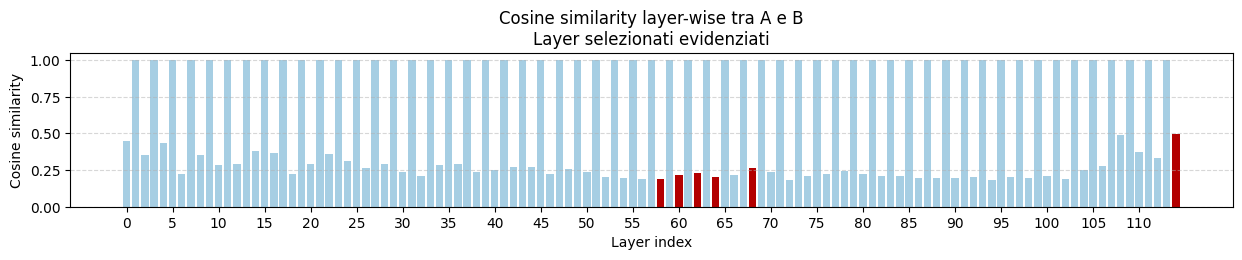

Analisi di Consistenza per top_p = 0.1


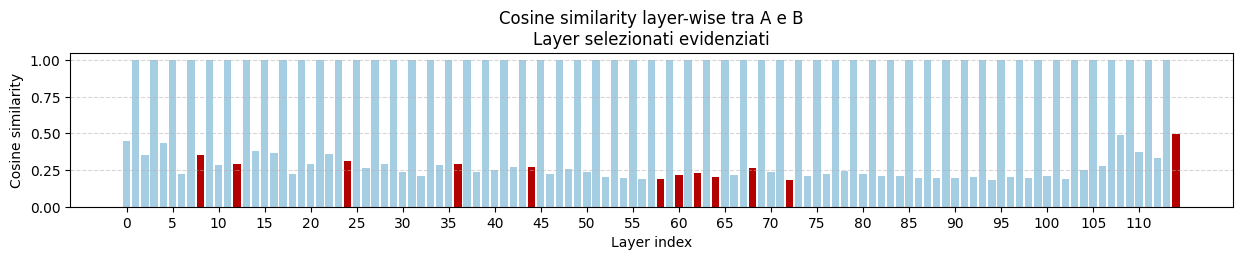

Analisi di Consistenza per top_p = 0.15


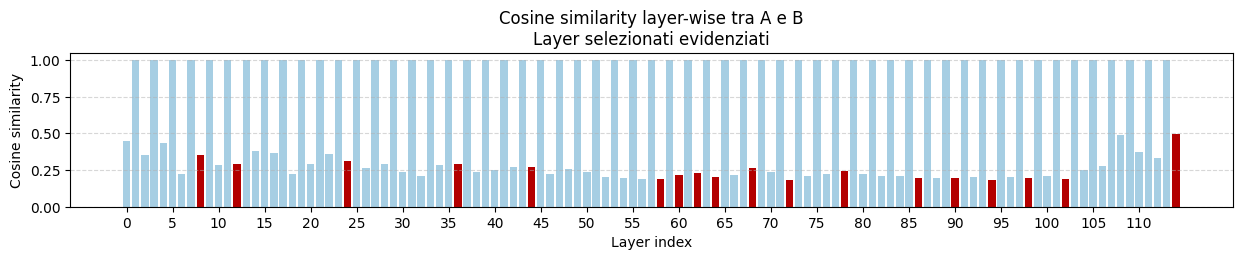

Analisi di Consistenza per top_p = 0.25


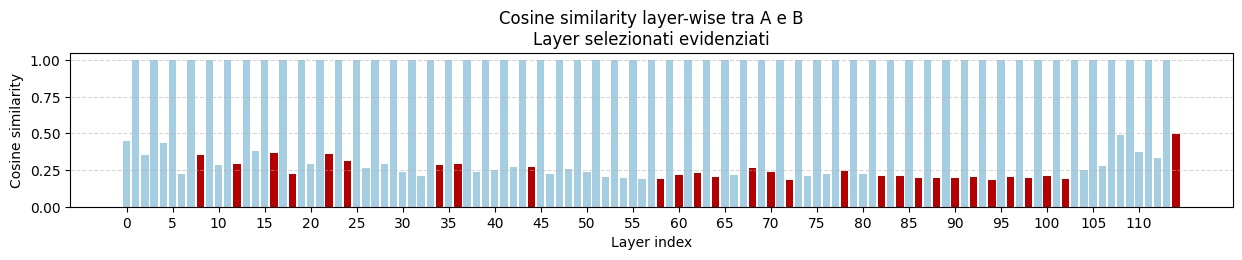

Analisi di Consistenza per top_p = 0.35


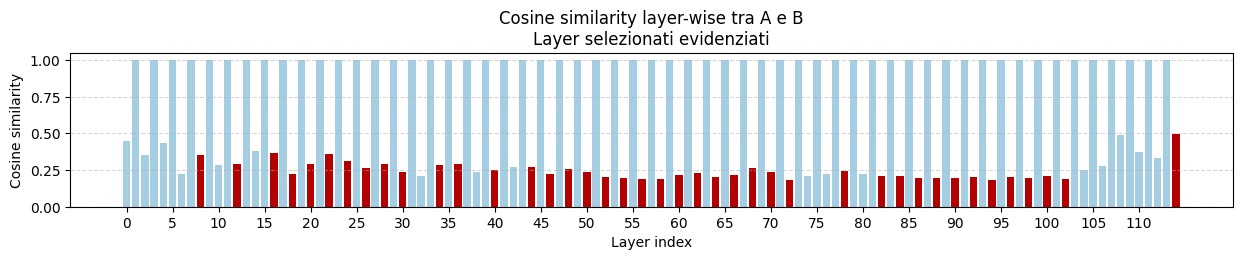

Analisi di Consistenza per top_p = 0.5


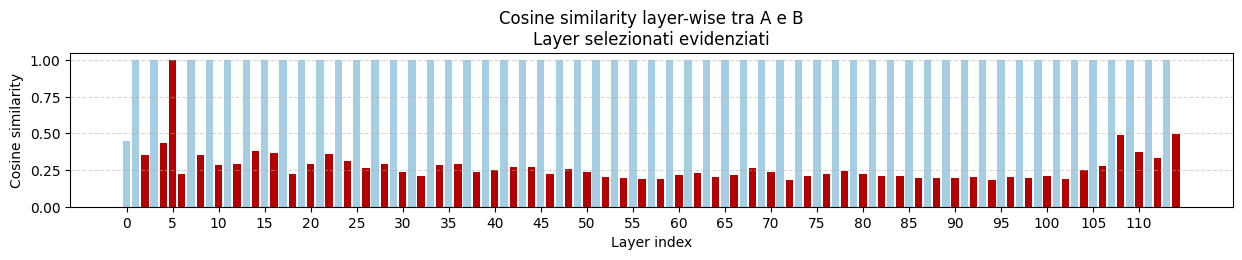

Analisi di Consistenza per top_p = 0.75


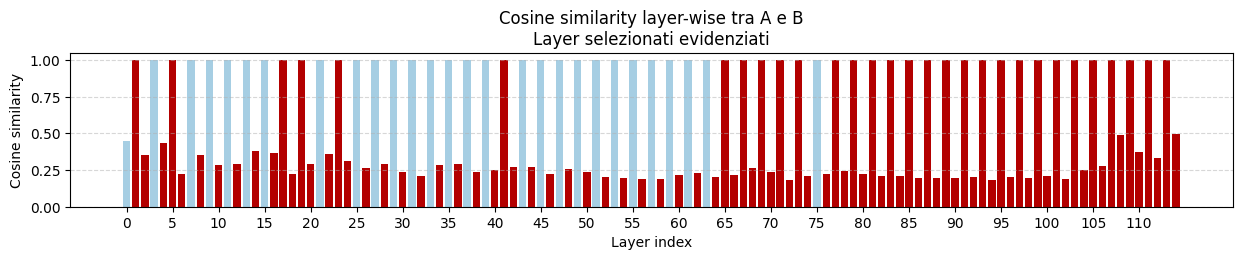

Analisi di Consistenza per top_p = 0.85


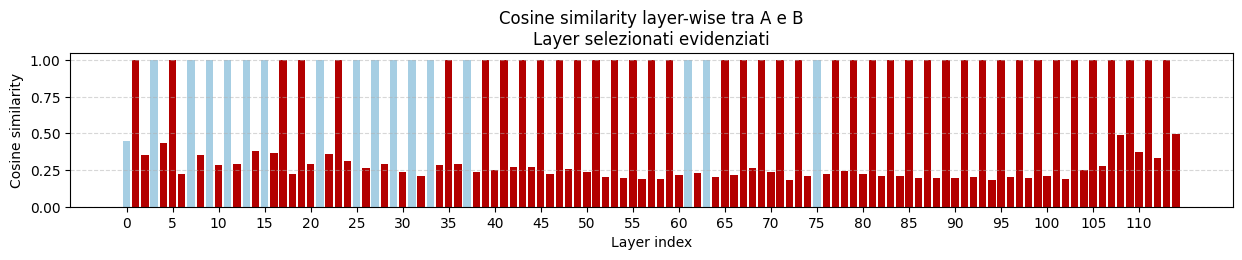

In [129]:
base_model_ref = model
expert_A = aligned_model_A
expert_B = aligned_model_B
LAYER_NAME_TO_IGNORE = 'fc'

delta_A_full = calculate_delta(expert_A, base_model_ref, layer_to_ignore=LAYER_NAME_TO_IGNORE)
delta_B_full = calculate_delta(expert_B, base_model_ref, layer_to_ignore=LAYER_NAME_TO_IGNORE)

layer_cos_sims = {}
for layer_idx in range(len(expert_A.layers)):
    keys_layer = [k for k in delta_A_full.keys() if k.startswith(f"layers.{layer_idx}.")]
    common_keys = [k for k in keys_layer if k in delta_B_full]

    if not common_keys:
        continue

    vec_A = torch.cat([delta_A_full[k].flatten() for k in common_keys])
    vec_B = torch.cat([delta_B_full[k].flatten() for k in common_keys])

    cos_sim = F.cosine_similarity(vec_A.float(), vec_B.float(), dim=0).item()
    layer_cos_sims[layer_idx] = cos_sim


num_layers = len(layer_cos_sims) 
layer_indices = sorted(layer_cos_sims.keys())
cos_sims = [layer_cos_sims[i] for i in layer_indices]

indices_selected = {}

colors_dict = {i: "#a6cee3" for i in range(num_layers)}


top_p = [0.05, 0.10, 0.15, 0.25, 0.35, 0.50, 0.75, 0.85]
for i in range(len(top_p)):
    print(f"Analisi di Consistenza per top_p = {top_p[i]}")
    avg_snrs = np.array([(snr_scores['model_A'][i] + snr_scores['model_B'][i]) / 2 for i in range(num_layers)])

    k = math.ceil(num_layers * top_p[i])
    indices_to_merge = np.argsort(avg_snrs[:num_layers])[-k:]
    indices_selected[top_p[i]] = sorted(list(indices_to_merge))
    for j in indices_selected[top_p[i]]:
        colors_dict[j] = "#b30000"

    plt.figure(figsize=(15, 2))
    plt.bar(range(num_layers), cos_sims, color=[colors_dict[i] for i in range(num_layers)], width=0.8)
    plt.xlabel("Layer index")
    plt.ylabel("Cosine similarity")
    plt.title("Cosine similarity layer-wise tra A e B\nLayer selezionati evidenziati")
    plt.ylim(0, 1.05)
    plt.xticks(range(0, num_layers, max(1, num_layers//20))) 
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

## Merging

Si implementa una funzione che permette di fare *merging* dei modelli considerando solo i layer più "importanti" classificandoli secondo il loro SNR. I layer restanti vengono copiati da un modello di riferimento. <br>
Il merging avviene sfruttando 3 diverse tecniche.<br>
- **LERP**: Consiste nel calcolare una media pesata dei parametri (pesi e bias) dei due modelli.
- **SLERP**: Questa tecnica interpola i parametri lungo un arco di cerchio su un'ipersfera.
- **TIES**: Tecnica che mira a risolvere le "interferenze" tra i parametri appresi dai due modelli fondendo solo quelli che hanno appreso nella stessa direzione rispetto a un modello di partenza. Paper di riferimento: [TIES-Merging: Resolving Interference When Merging Models](https://arxiv.org/abs/2306.01708)

In [ ]:
from src.merge import slerp_merging, ties_merging_layer, merge_models_top_p, calculate_layer_similarities
from src.utils import calculate_delta

In [ ]:

delta_A = calculate_delta(aligned_model_A, model, layer_to_ignore='fc')
delta_B = calculate_delta(aligned_model_B, model, layer_to_ignore='fc')
similarities_per_layer = calculate_layer_similarities(delta_A, delta_B, model.layers)


analysis_targets = []
percentages = [0.05, 0.10, 0.15, 0.25, 0.45, 0.50, 0.75, 0.85]
merge_methods = ['lerp', 'slerp', 'ties']
selection_criteria_list = ['snr', 'similarity', 'hybrid']


for criteria in selection_criteria_list:
    for p in percentages:
        for method in merge_methods:
            
            indices, merged_model = merge_models_top_p(
                model_a=aligned_model_A,
                model_b=aligned_model_B,
                base_model=deepcopy(model),
                snr_a=snr_scores['model_A'],
                snr_b=snr_scores['model_B'],
                layer_similarities=similarities_per_layer,
                top_p=p,
                merge_method=method,
                selection_criteria=criteria 
            )
            
            model_name = f"{method.upper()} ({criteria.capitalize()}) {int(p*100)}%"
            
            analysis_targets.append({
                "name": model_name,
                "model": merged_model,
                "indices": indices
            })



for method in merge_methods:
    indices, merged_model = merge_models_top_p(
        model_a=aligned_model_A,
        model_b=aligned_model_B,
        base_model=deepcopy(model),
        snr_a=snr_scores['model_A'],
        snr_b=snr_scores['model_B'],
        layer_similarities=similarities_per_layer,
        top_p=1.0, 
        merge_method=method,
        selection_criteria='snr' 
    )
    analysis_targets.append({
        "name": f"Full {method.upper()}",
        "model": merged_model,
        "indices": indices
    })


## Valutazione delle diverse tecniche

In [ ]:


models_to_evaluate = {
    "Modello Base": model,
    "Esperto A (Geometrico)": aligned_model_A,
    "Esperto B (Fotometrico)": aligned_model_B,
}


for target in analysis_targets:
    models_to_evaluate[target["name"]] = target["model"]



results = {}

for name, model_to_test in models_to_evaluate.items():
    print(f"Valutazione in corso: {name}")
    
    acc_std, f1_std = evaluate_model(model_to_test, loader_full_test, device=device)
    
    acc_hard, f1_hard = evaluate_model(model_to_test, loader_full_test_hard, device=device)
    
    acc_c, f1_c = evaluate_model(model_to_test, loader_C_test, device=device)

    results[name] = {
        "Accuratezza Standard": acc_std, 
        "F1 Standard": f1_std, 
        "Accuratezza Difficile": acc_hard, 
        "F1 Difficile": f1_hard,
        "Accuratezza C (Occlusion)": acc_c,
        "F1 C (Occlusion)": f1_c
    }



df_results = pd.DataFrame.from_dict(results, orient='index')


df_results = df_results.round(2)


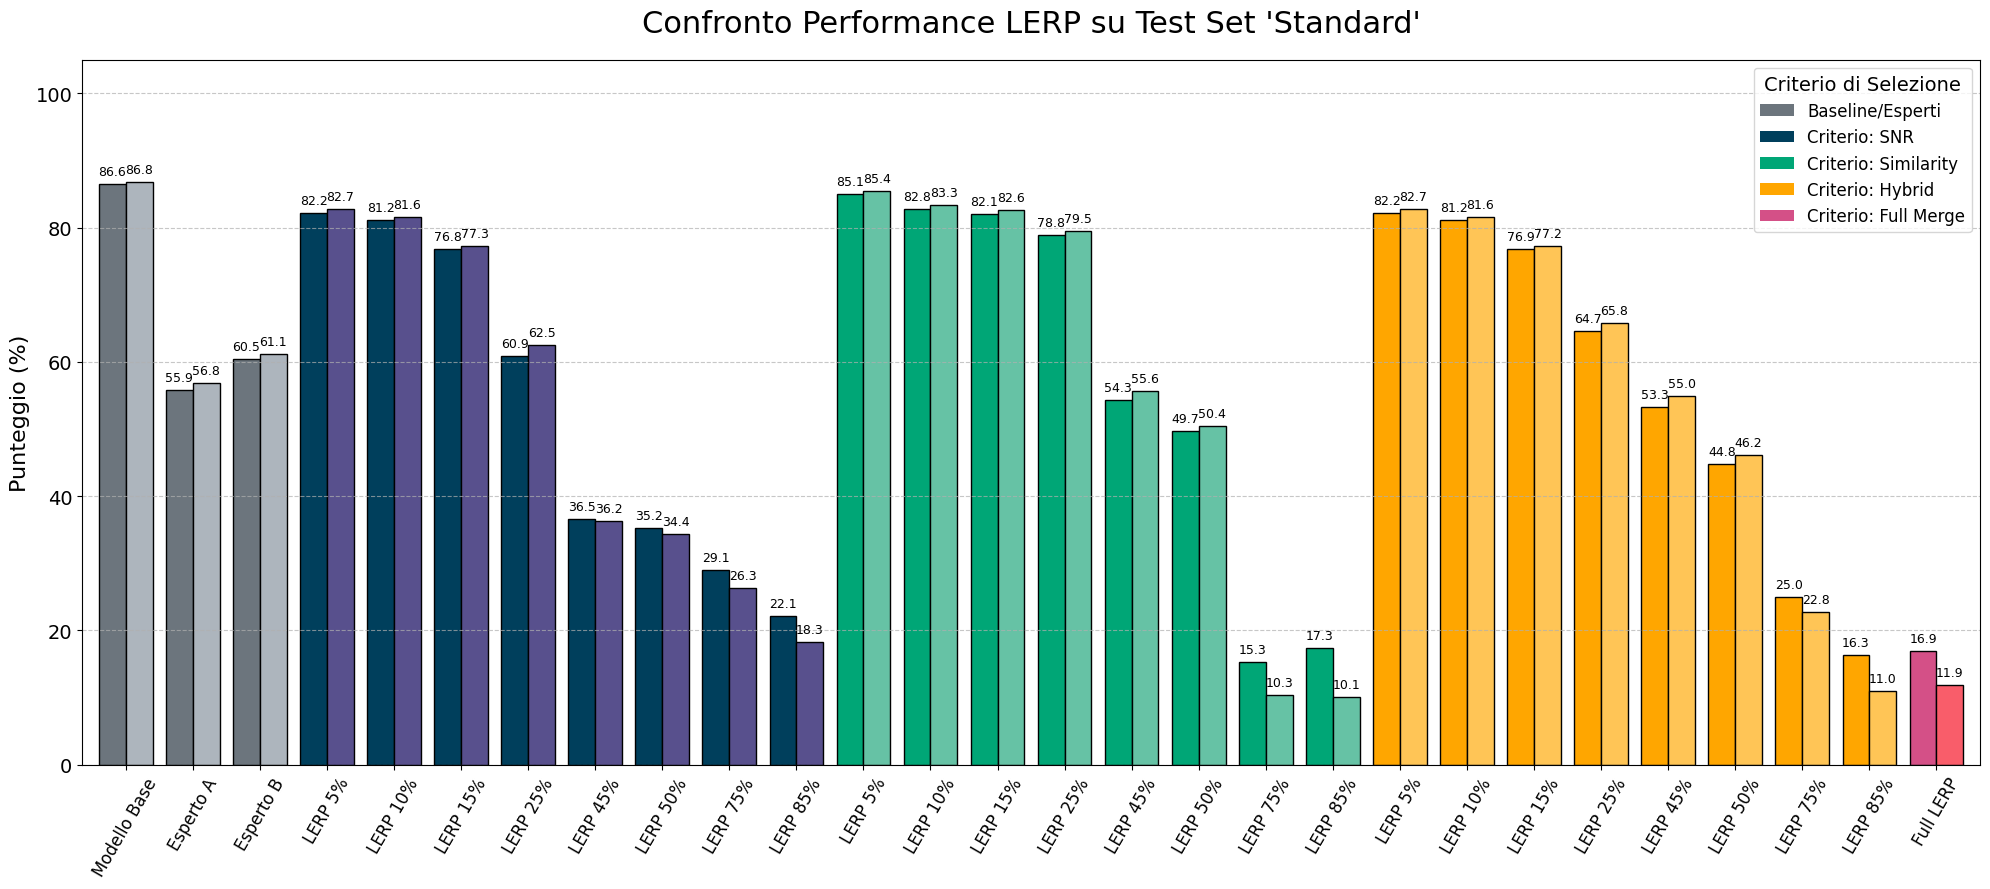

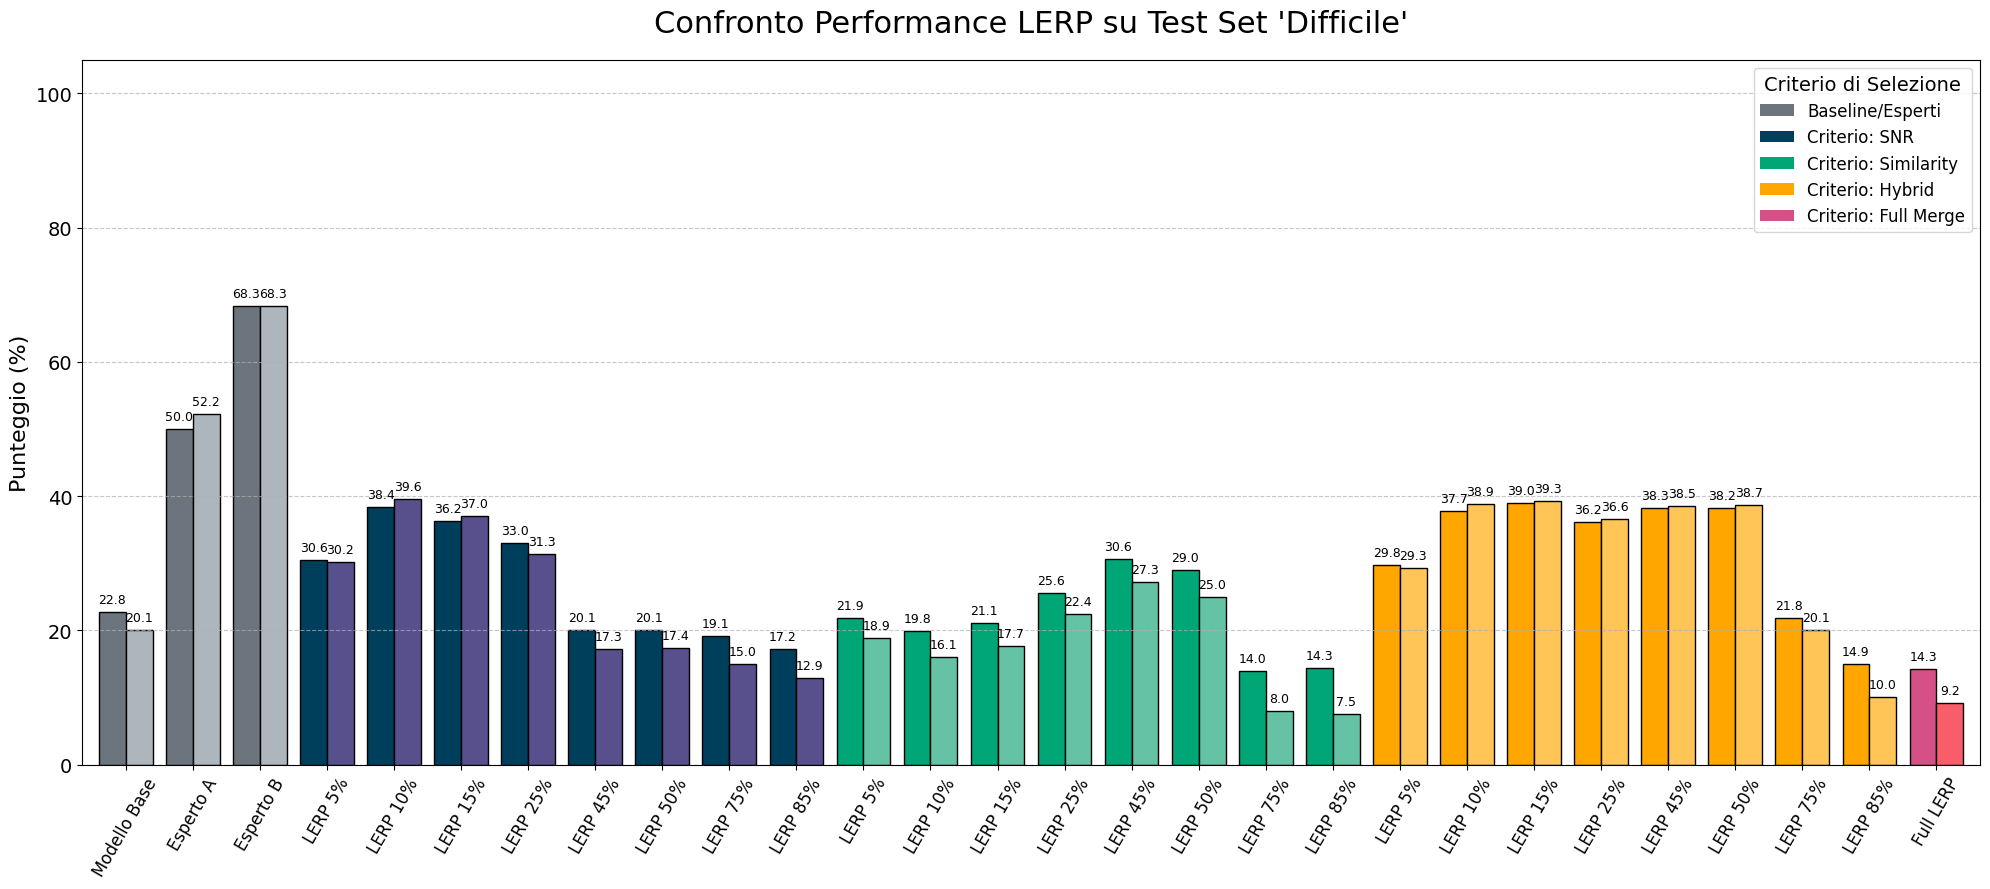

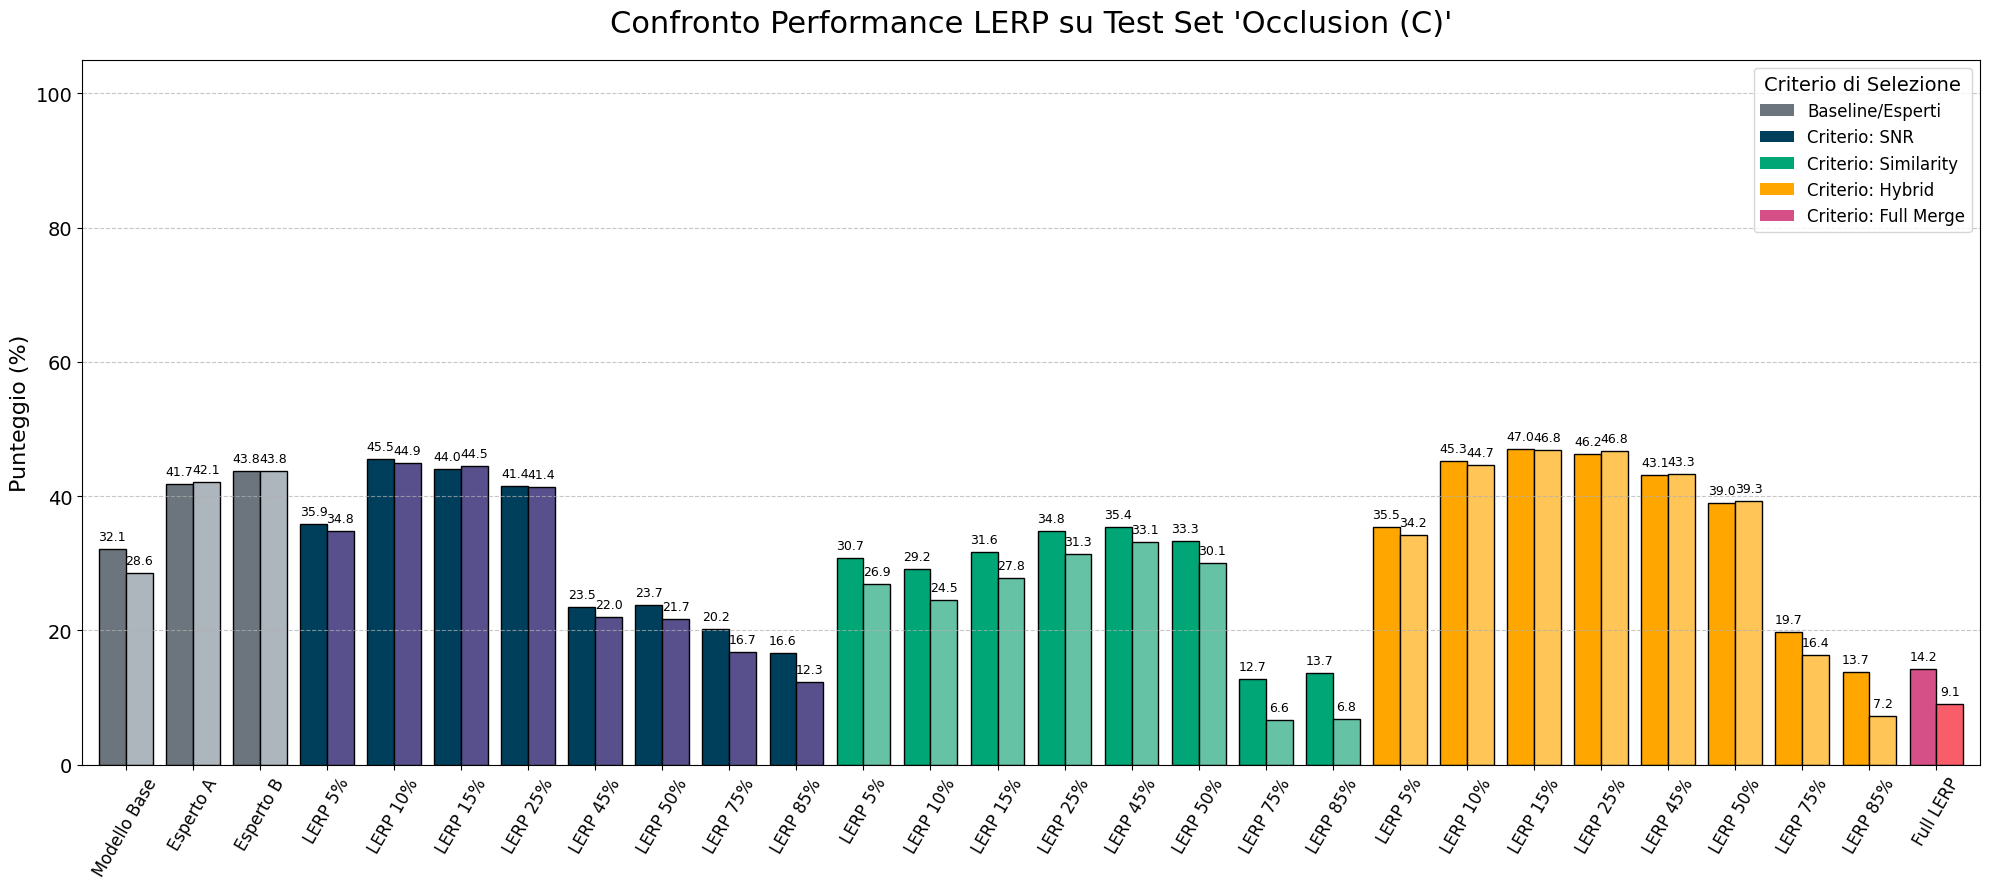

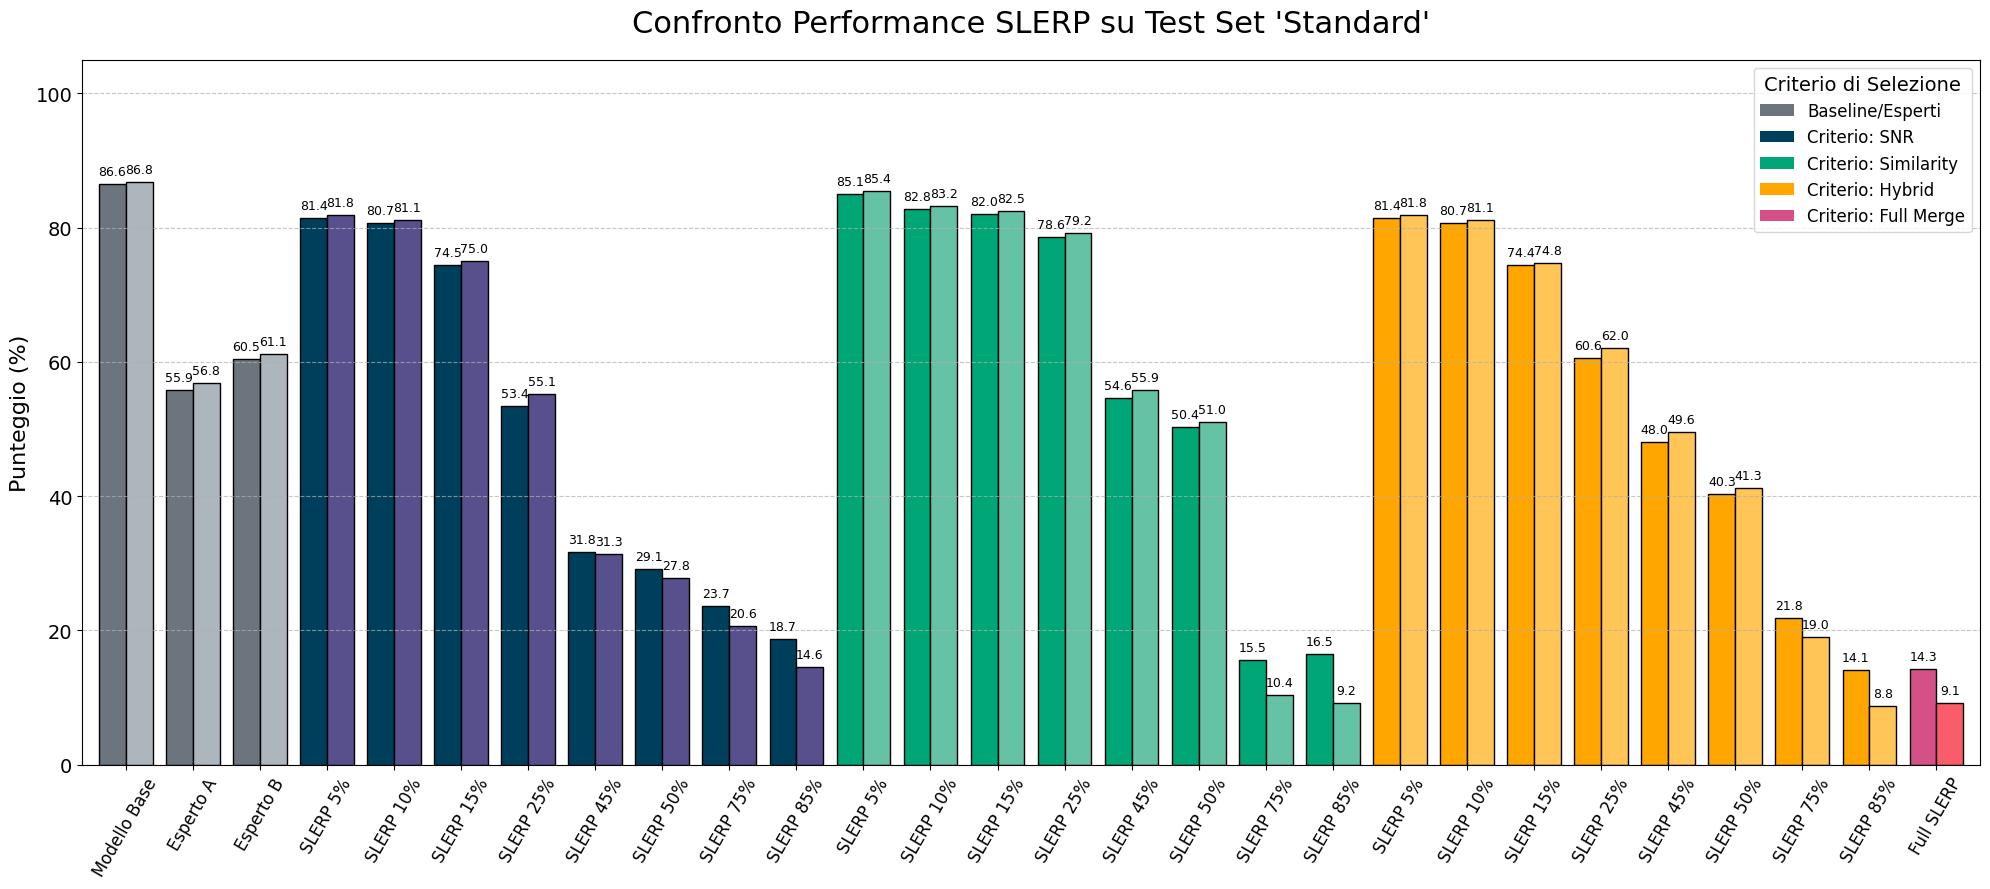

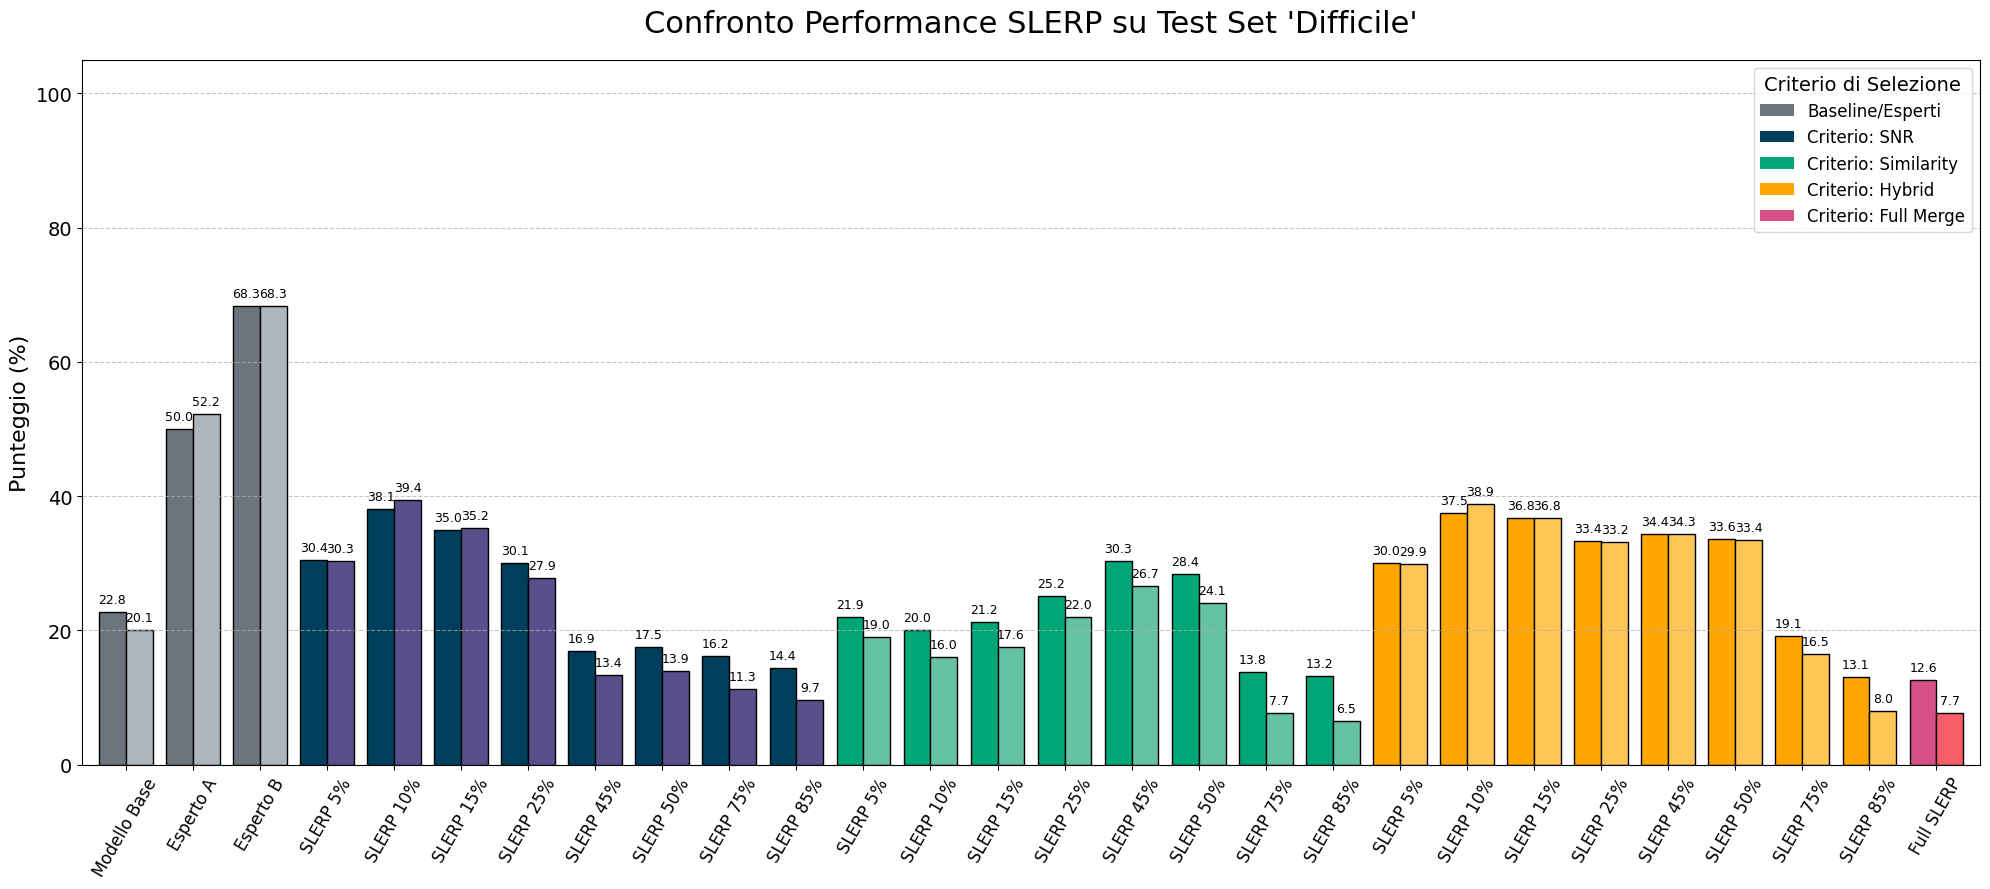

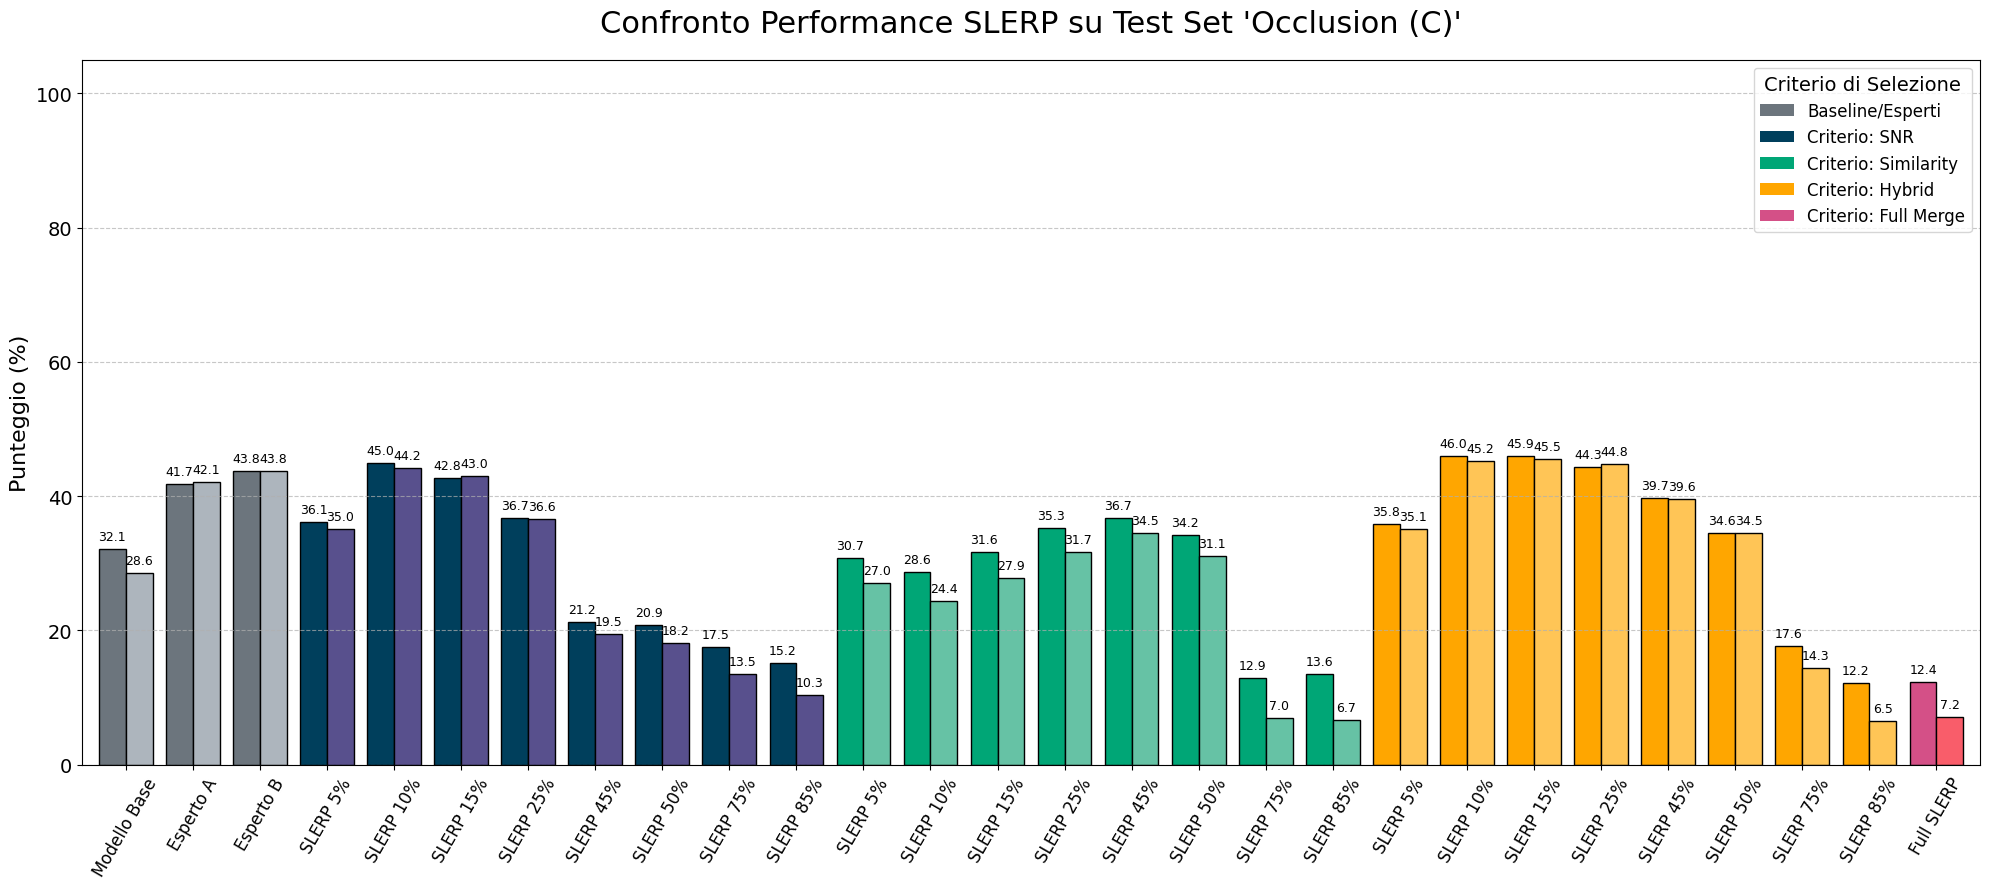

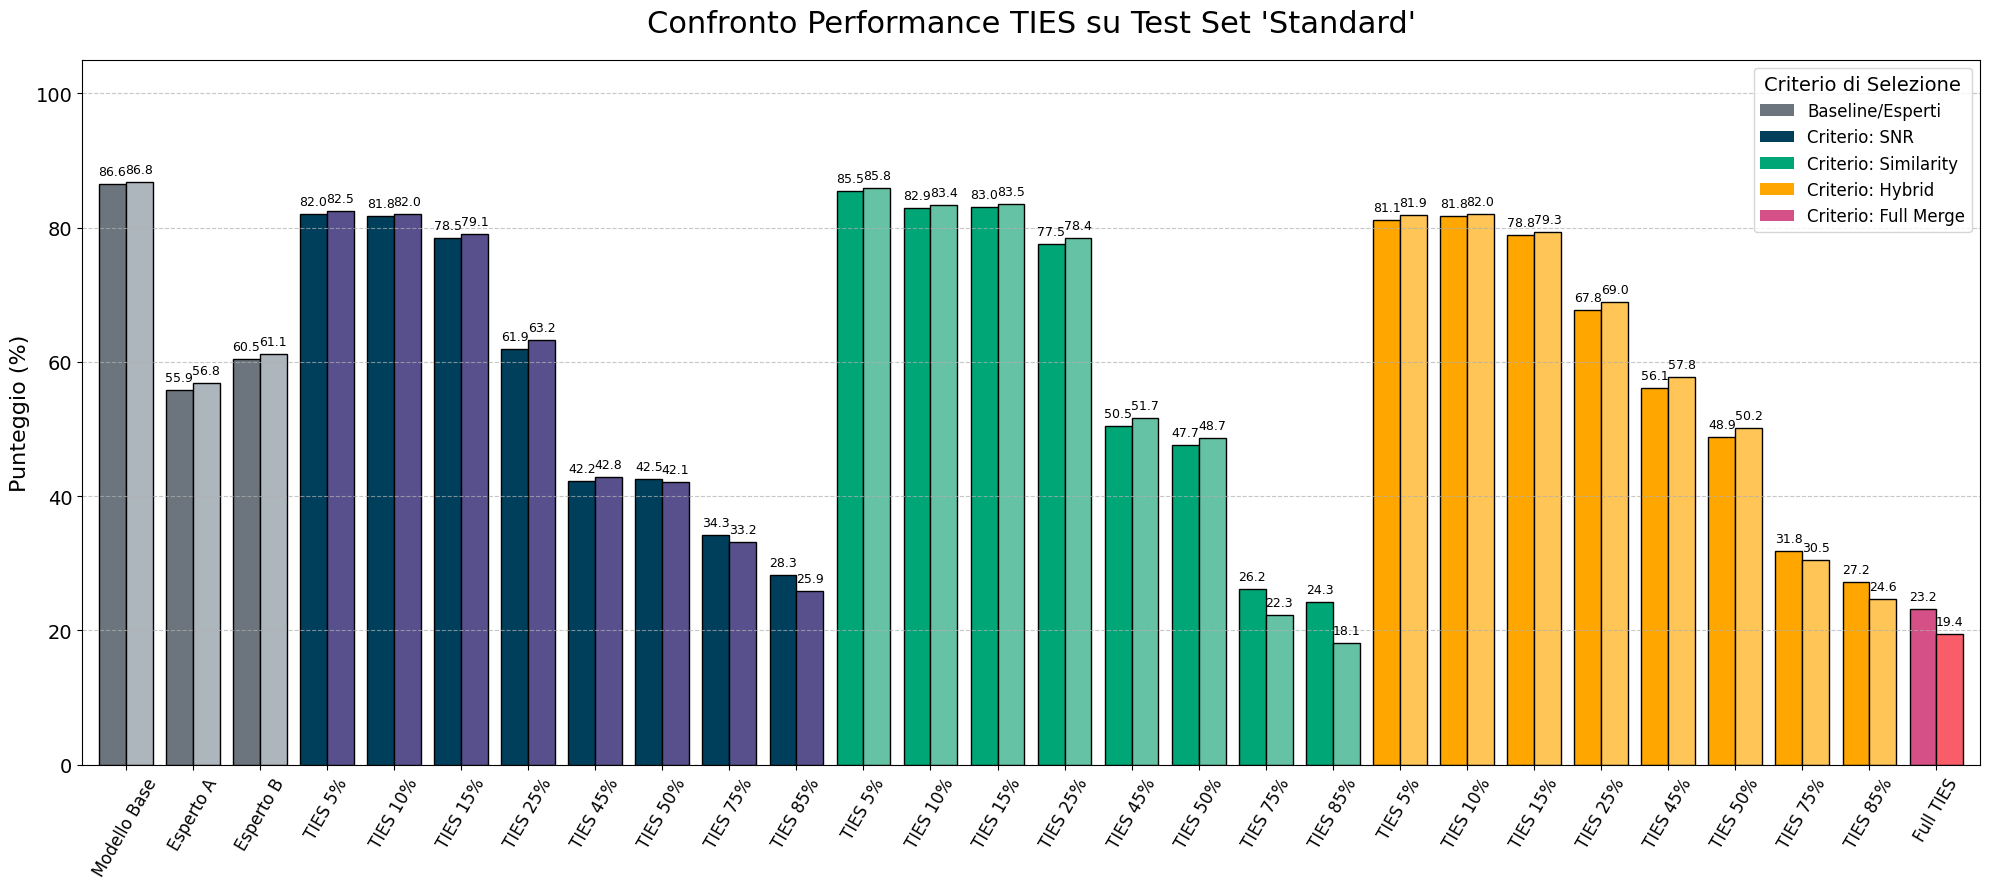

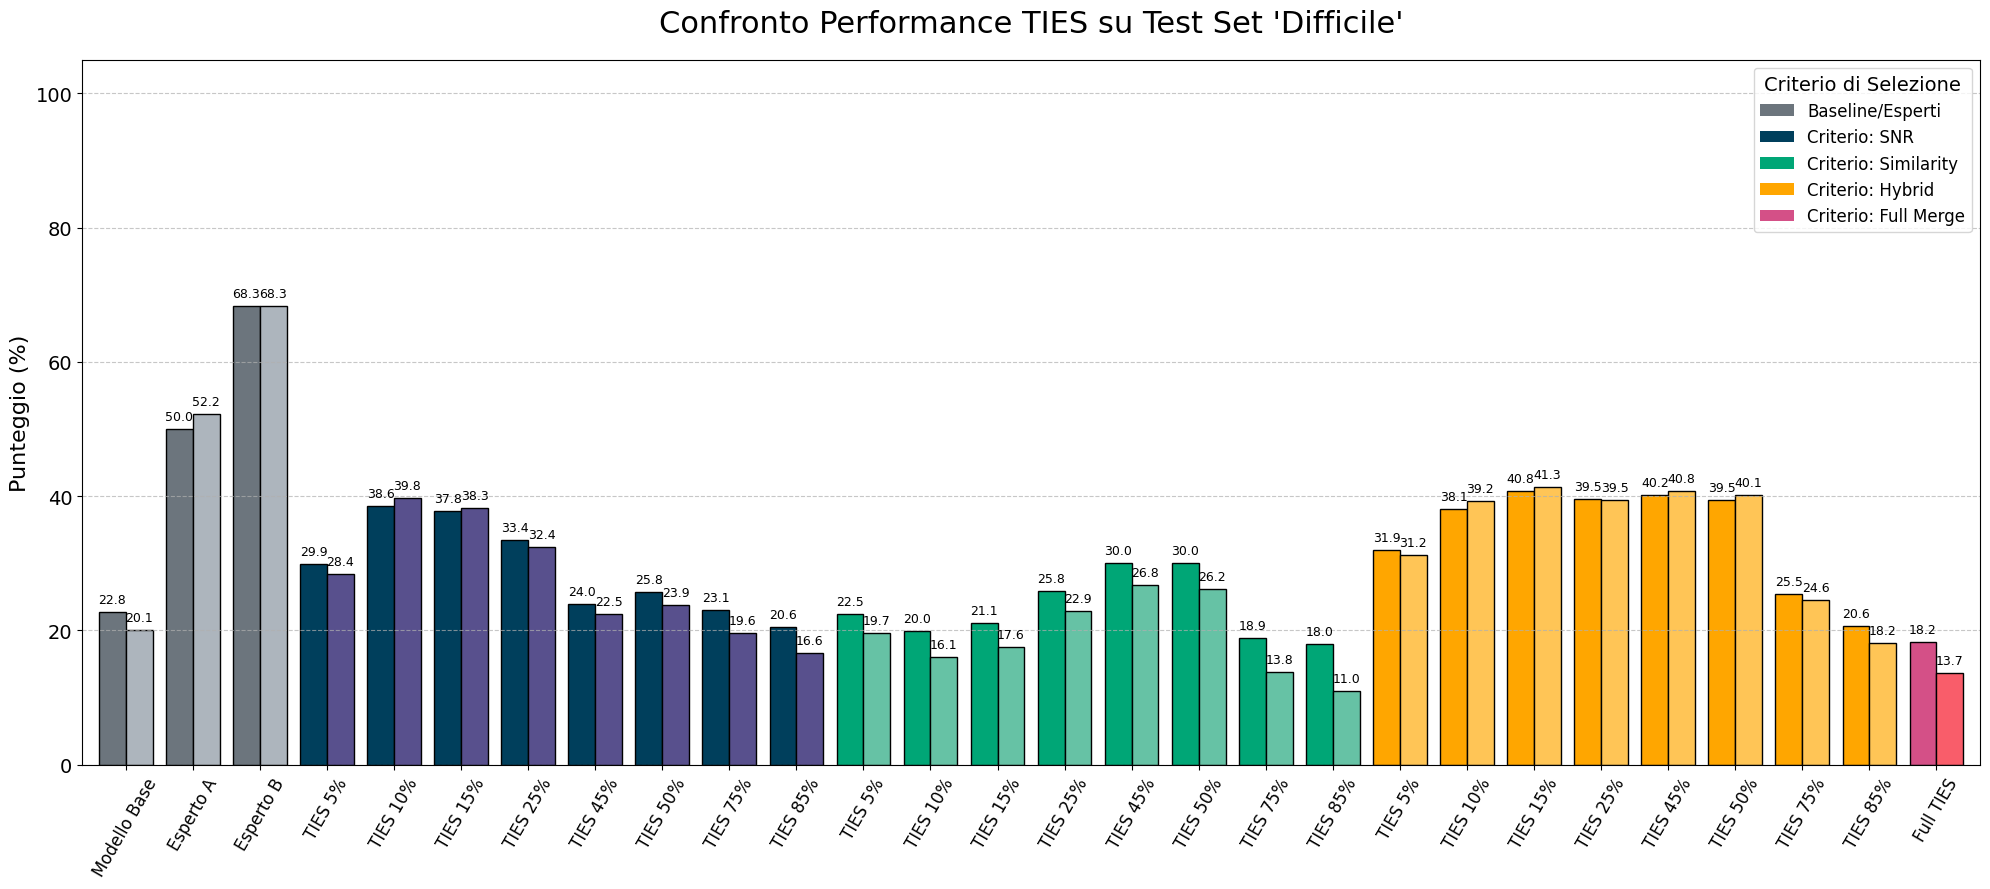

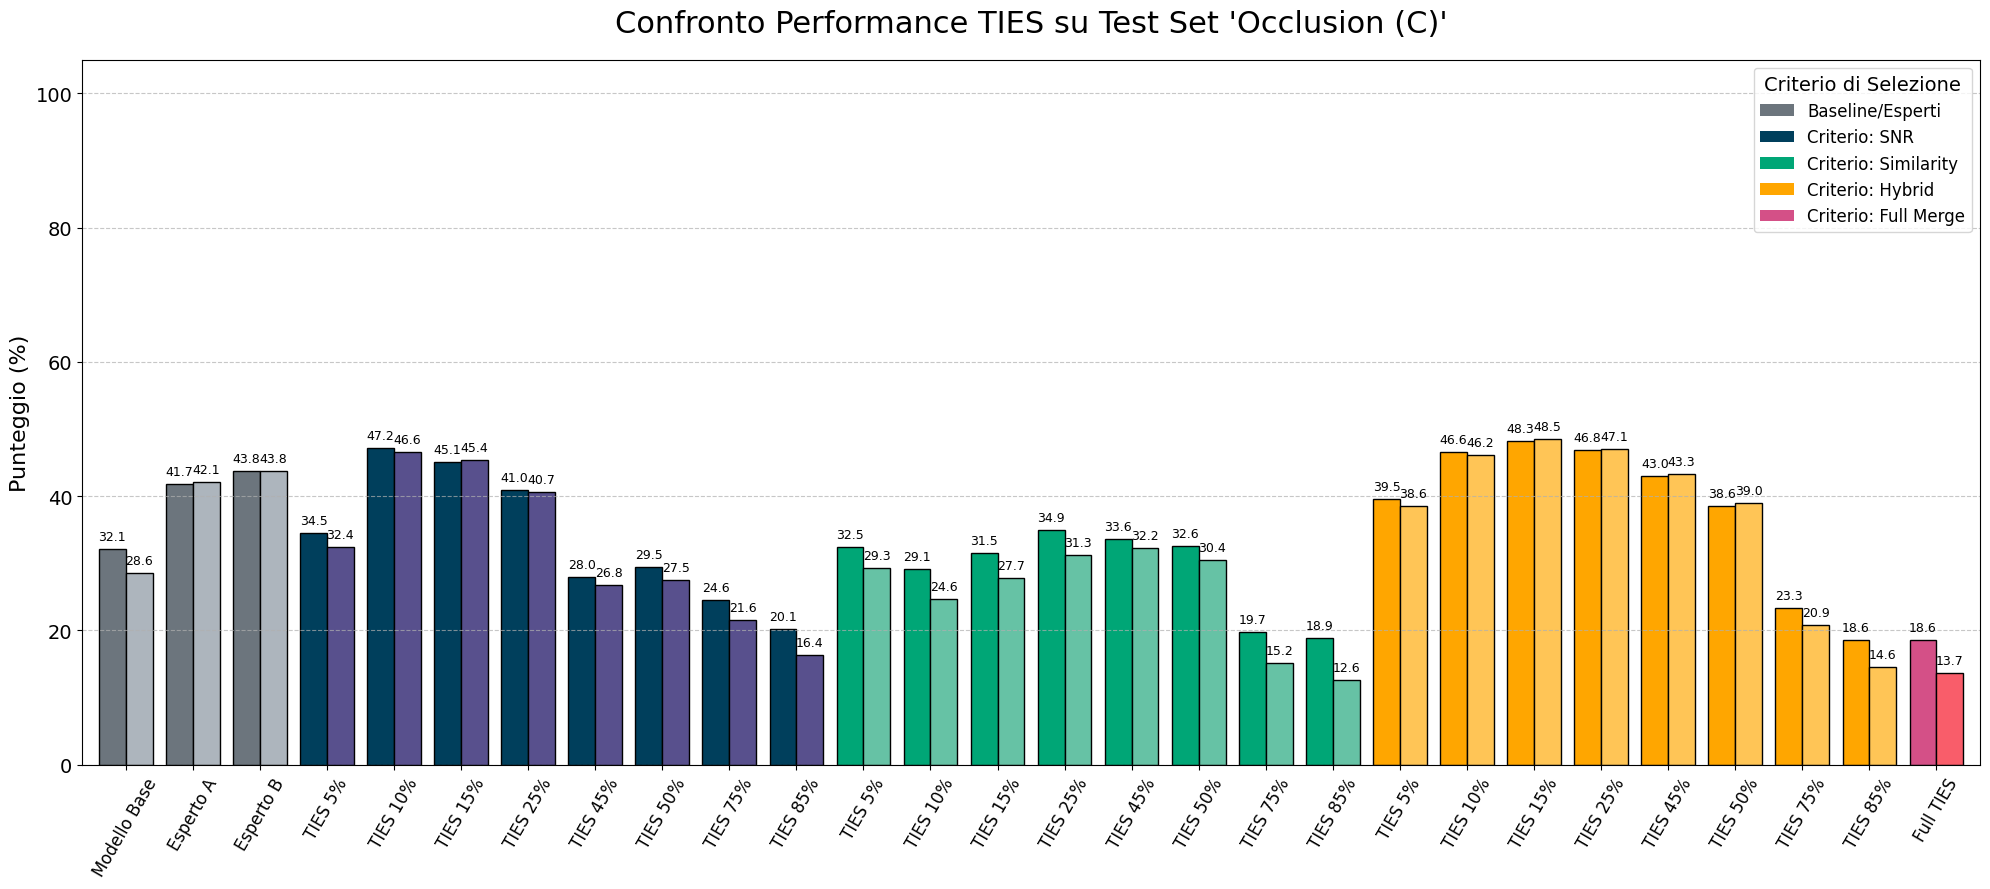

In [ ]:


def plot_model_comparison(df, models_to_plot, metrics_to_plot, title, base_colors):
    """
    Funzione riutilizzabile che assegna colori dinamici e formatta le etichette dell'asse x.
    """
    if not all(m in df.index for m in models_to_plot):
        print(f"Grafico '{title}' saltato: alcuni modelli mancano nei risultati.")
        return

    subset_df = df.loc[models_to_plot].copy()
    subset_df[metrics_to_plot] = subset_df[metrics_to_plot]
    
    ax = subset_df[metrics_to_plot].plot(
        kind='bar',
        figsize=(20, 9),
        rot=60,
        edgecolor='black',
        width=0.8,
        color=base_colors
    )


    criteria_colors = {
        "Snr": ('#003f5c', '#58508d'), "Similarity": ('#00a676', '#66c2a5'),
        "Hybrid": ('#ffa600', '#ffc556'), "Full": ('#d45087', '#f95d6a'),
        "Base": ('#6c757d', '#adb5bd')
    }
    n_metrics = len(metrics_to_plot)
    n_models = len(models_to_plot)
    for i, patch in enumerate(ax.patches):
        model_index = i % n_models
        metric_index = i // n_models
        model_name = models_to_plot[model_index]
        palette = criteria_colors["Snr"]
        if "Base" in model_name or "Esperto" in model_name: palette = criteria_colors["Base"]
        elif "Full" in model_name: palette = criteria_colors["Full"]
        elif "(Snr)" in model_name: palette = criteria_colors["Snr"]
        elif "(Similarity)" in model_name: palette = criteria_colors["Similarity"]
        elif "(Hybrid)" in model_name: palette = criteria_colors["Hybrid"]
        patch.set_facecolor(palette[metric_index])
    

    ax.set_title(title, fontsize=22, pad=20)
    ax.set_ylabel('Punteggio (%)', fontsize=16)
    ax.set_xlabel('')
    ax.set_ylim(0, 105)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    

    cleaned_labels = [re.sub(r'\s\([^)]*\)', '', name) for name in models_to_plot]
    ax.set_xticklabels(cleaned_labels, rotation=60, ha='center', fontsize=12)

    legend_elements = [
        Patch(facecolor=criteria_colors['Base'][0], label='Baseline/Esperti'),
        Patch(facecolor=criteria_colors['Snr'][0], label='Criterio: SNR'),
        Patch(facecolor=criteria_colors['Similarity'][0], label='Criterio: Similarity'),
        Patch(facecolor=criteria_colors['Hybrid'][0], label='Criterio: Hybrid'),
        Patch(facecolor=criteria_colors['Full'][0], label='Criterio: Full Merge'),
    ]
    ax.legend(handles=legend_elements, title="Criterio di Selezione", fontsize=12, title_fontsize=14)

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=9)
    
    plt.tight_layout()
    plt.show()


always_keep = ["Modello Base", "Esperto A (Geometrico)", "Esperto B (Fotometrico)"]
model_groups = {
    "LERP": [m for m in df_results.index if "LERP" in m.split()],
    "SLERP": [m for m in df_results.index if "SLERP" in m.split()],
    "TIES": [m for m in df_results.index if "TIES" in m.split()]
}
metric_groups = {
    "Standard": {"cols": ["Accuratezza Standard", "F1 Standard"], "color": ['#1f77b4', '#aec7e8']},
    "Difficile": {"cols": ["Accuratezza Difficile", "F1 Difficile"], "color": ['#d62728', '#ff9896']},
    "Occlusion (C)": {"cols": ["Accuratezza C (Occlusion)", "F1 C (Occlusion)"], "color": ['#2ca02c', '#98df8a']}
}


for merge_method, group_models in model_groups.items():
    if not group_models: continue
    for test_set_name, metric_details in metric_groups.items():
        plot_title = f"Confronto Performance {merge_method} su Test Set '{test_set_name}'"
        
        def sort_key(name):
            if "(Snr)" in name: criteria_order = 0
            elif "(Similarity)" in name: criteria_order = 1
            elif "(Hybrid)" in name: criteria_order = 2
            elif "Full" in name: criteria_order = 3
            else: criteria_order = 0 
            parts = name.split(' ')
            if 'Full' in name: percent = 100
            else:
                try: percent = int(parts[-1].replace('%', ''))
                except (ValueError, IndexError): percent = 0
            return (criteria_order, percent)

        models_for_plot = always_keep + sorted(group_models, key=sort_key)
        
        plot_model_comparison(
            df=df_results,
            models_to_plot=models_for_plot,
            metrics_to_plot=metric_details["cols"],
            title=plot_title,
            base_colors=metric_details["color"]
        )

## Fine-tuning successivo

É necessario verificare come si comportano i nuovi modelli. Per seguire quanto descritto nel paper di riferimento, si "congelano" alcuni layer per addestrare solo quelli interessati dal merging (e necessariamente anche l'output layer)

In [115]:
from src.utils import freeze_layers_selectively

Si calcolano accuratezza e F1-Score prima e dopo il fine-tuning del modello baseline, di un modello con merging non allineato (se l'allineamento ha senso) e di tutti i modelli fusi. Questi ultimi vengono addestrati congelando tutti i layer eccetto quello di output, congelando tutti i layer non selezionati in base all'SNR e senza congelamenti. Un'accuratezza o F1-score inferiore al modello baseline prima del fine-tuning indica un modello poco efficace. Ci si aspetta di migliorare le metriche di valutazione con i modelli addestrati senza congelamenti. Si auspica in metriche comparabili o superiori al modello baseline fine-tuned per quanto riguarda i modelli addestrati con layer congelati, a fronte di picchi di memoria e tempi di addestramento piú bassi.

In [120]:
from src.test import finetuning_experiments
indices_no_merge_15, test_no_merge_15 = merge_models_top_p(
    model_a=aligned_model_A,
    model_b=aligned_model_B,
    base_model=deepcopy(model),
    snr_a=snr_scores['model_A'],
    snr_b=snr_scores['model_B'],
    layer_similarities=similarities_per_layer,
    top_p=0.15,
    selection_criteria='snr',
)

models_name_list = ["TIES (Snr) 10%", "TIES (Hybrid) 15%", "LERP (Snr) 10%", "LERP (Hybrid) 15%", "Full TIES"]
merged_models_to_evaluate = {"No Merge 15%": {"model": test_no_merge_15, "indices": indices_no_merge_15}}
for elem in analysis_targets:
    if elem["name"] in models_name_list:
        merged_models_to_evaluate[elem["name"]] = {"model": elem["model"], "indices": elem["indices"]}


results = finetuning_experiments(model, model_A, model_B, merged_models_to_evaluate, loader_C_train, loader_C_test, device, is_alignment_noop, epochs_base=5, lr_base=1e-4, epochs_merged=5, lr_merged=1e-4)


Test: Fine-Tuning del Modello Base (No-Merge)...
Inizio addestramento per 5 epoche...
Epoch 1/5 -> Loss: 0.7901, Accuracy sul Test Set: 76.50%, F1-Score: 76.51%
Epoch 2/5 -> Loss: 0.5435, Accuracy sul Test Set: 78.43%, F1-Score: 78.36%
Epoch 3/5 -> Loss: 0.4901, Accuracy sul Test Set: 79.61%, F1-Score: 79.48%
Epoch 4/5 -> Loss: 0.4572, Accuracy sul Test Set: 80.52%, F1-Score: 80.51%
Epoch 5/5 -> Loss: 0.4328, Accuracy sul Test Set: 81.27%, F1-Score: 81.21%
Addestramento completato.

Test: Fusione Naive (Senza Allineamento)...
L'allineamento non ha modificato i pesi di model_B quindi testare il modello non allineato non ha senso.

--- Analisi: No Merge 15% (Only Head) ---
Pesi del corpo trasferiti da backbone a esperto (output_size=10).
Accuratezza Zero-Shot: 44.79%, F1-Score: 45.17%
Strategia: Fine-tuning solo della testa (head).
Inizio addestramento per 5 epoche...
Epoch 1/5 -> Loss: 1.0619, Accuracy sul Test Set: 71.38%, F1-Score: 71.46%
Epoch 2/5 -> Loss: 1.0383, Accuracy sul Test 

In [121]:
#Intestazione della tabella
header = (
    f"{'Modello (Strategia)':<55} | "
    f"{'Acc. Zero-Shot (%)':<22} | "
    f"{'Acc. Fine-Tuned (%)':<22} | "
    f"{'F1 Fine-Tuned (%)':<22} | "
    f"{'Tempo Add. (s)':<18} | "
    f"{'Picco RAM (GB)':<18}"
)
print(header)
print("-"*150)


for name, res_data in results.items():
    acc_zs = res_data.get('acc_zero_shot')
    acc_ft = res_data.get('acc_finetuned')
    f1_ft = res_data.get('f1_finetuned')
    t = res_data.get('time')
    mem = res_data.get('ram_gb')

    #("N/A" se un dato non è applicabile)
    acc_zs_str = f"{acc_zs:.2f}" if acc_zs is not None else "N/A"
    acc_ft_str = f"{acc_ft:.2f}" if acc_ft is not None else "N/A"
    f1_ft_str = f"{f1_ft:.2f}" if f1_ft is not None else "N/A"
    t_str = f"{t:.2f}" if t is not None else "N/A"
    mem_str = f"{mem:.2f}" if mem is not None else "N/A"

    print(
        f"{name:<55} | "
        f"{acc_zs_str:<22} | "
        f"{acc_ft_str:<22} | "
        f"{f1_ft_str:<22} | "
        f"{t_str:<18} | "
        f"{mem_str:<18}"
    )

Modello (Strategia)                                     | Acc. Zero-Shot (%)     | Acc. Fine-Tuned (%)    | F1 Fine-Tuned (%)      | Tempo Add. (s)     | Picco RAM (GB)    
------------------------------------------------------------------------------------------------------------------------------------------------------
Base Model + Fine-Tune                                  | 31.70                  | 81.10                  | 81.08                  | 48.46              | 5.05              
No Merge 15% (Only Head)                                | 44.79                  | 71.30                  | 71.37                  | 18.00              | 0.75              
No Merge 15% (Selective FT)                             | 43.99                  | 78.22                  | 78.22                  | 39.76              | 4.60              
LERP (Snr) 10% (Only Head)                              | 45.59                  | 70.72                  | 70.81                  | 18.31              | 0.7

## Plot finali

In [122]:
from src.utils import get_plot_colors, get_group_name, extract_metrics_from_results
baseline_model_name = "Base Model + Fine-Tune"
metrics = extract_metrics_from_results(results, baseline_model_name)

labels_acc, data_acc, baseline_acc, min_baseline_acc = metrics["acc"]
labels_f1, data_f1, baseline_f1, min_baseline_f1 = metrics["f1"]
labels_time, data_time, baseline_time = metrics["time"]
labels_mem, data_mem, baseline_mem = metrics["mem"]

Grafico 1: Accuratezza Fine-Tuned

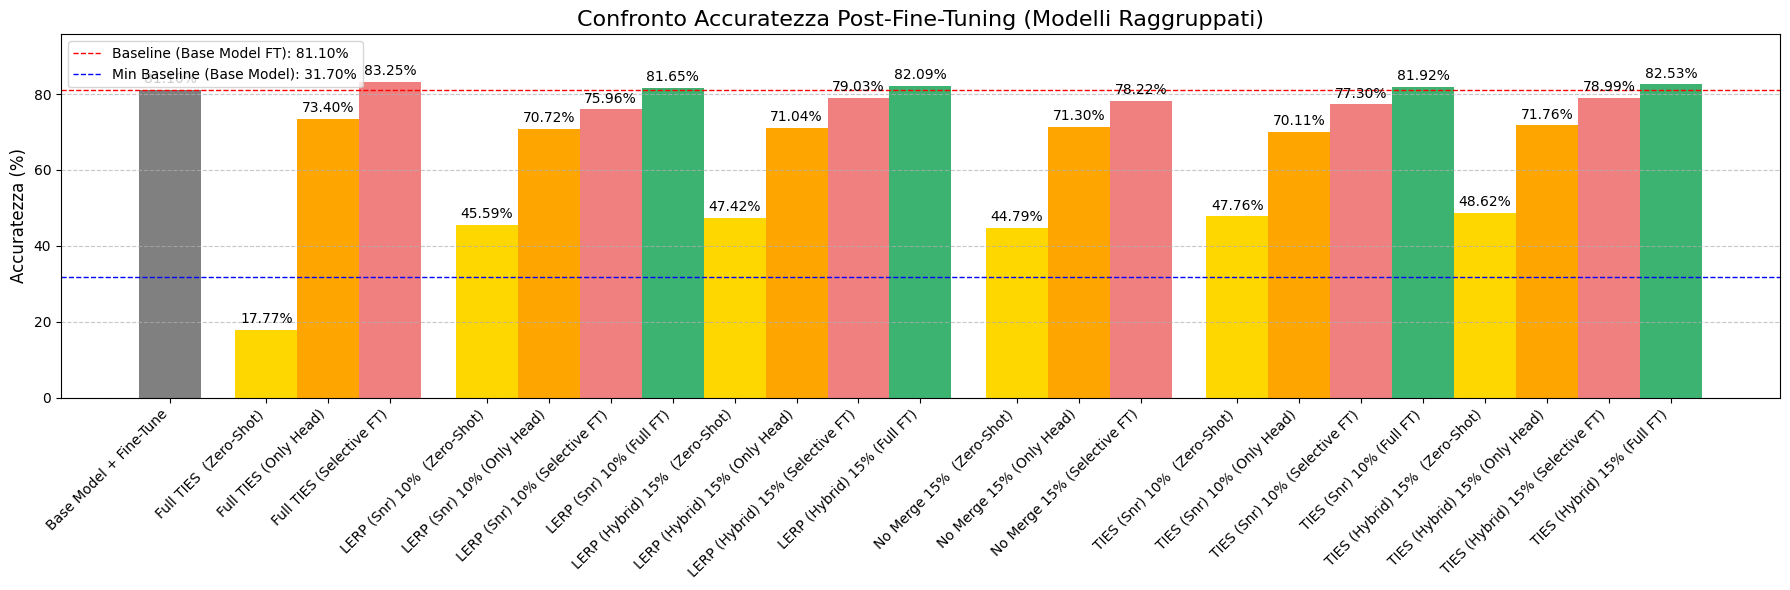

In [123]:
if data_acc:
    plt.figure(figsize=(18, 6))


    zipped_data = sorted(zip(labels_acc, data_acc), key=lambda x: get_group_name(x[0]))
    sorted_labels = [item[0] for item in zipped_data]
    sorted_data = [item[1] for item in zipped_data]

    bar_width = 0.9
    group_gap = 0.5
    x_positions = []
    current_x = 0
    for i, name in enumerate(sorted_labels):
        if i > 0 and get_group_name(name) != get_group_name(sorted_labels[i-1]):
            current_x += group_gap
        x_positions.append(current_x)
        current_x += bar_width


    colors = get_plot_colors(sorted_labels)
    bars = plt.bar(x_positions, sorted_data, color=colors, width=bar_width)

    if baseline_acc is not None:
        plt.axhline(y=baseline_acc, color='r', linestyle='--', linewidth=1, label=f'Baseline (Base Model FT): {baseline_acc:.2f}%')
        plt.legend()
    if min_baseline_acc is not None and min_baseline_acc != baseline_acc:
        plt.axhline(y=min_baseline_acc, color='blue', linestyle='--', linewidth=1, label=f'Min Baseline (Base Model): {min_baseline_acc:.2f}%')
        plt.legend()
    plt.ylabel('Accuratezza (%)', fontsize=12)
    plt.title('Confronto Accuratezza Post-Fine-Tuning (Modelli Raggruppati)', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(sorted_data) * 1.15)


    plt.xticks(ticks=x_positions, labels=sorted_labels, rotation=45, ha="right")

    for i, bar in enumerate(bars):
        yval = bar.get_height()
        plt.text(x_positions[i], yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

Grafico 2: F1-Score Fine-Tuned

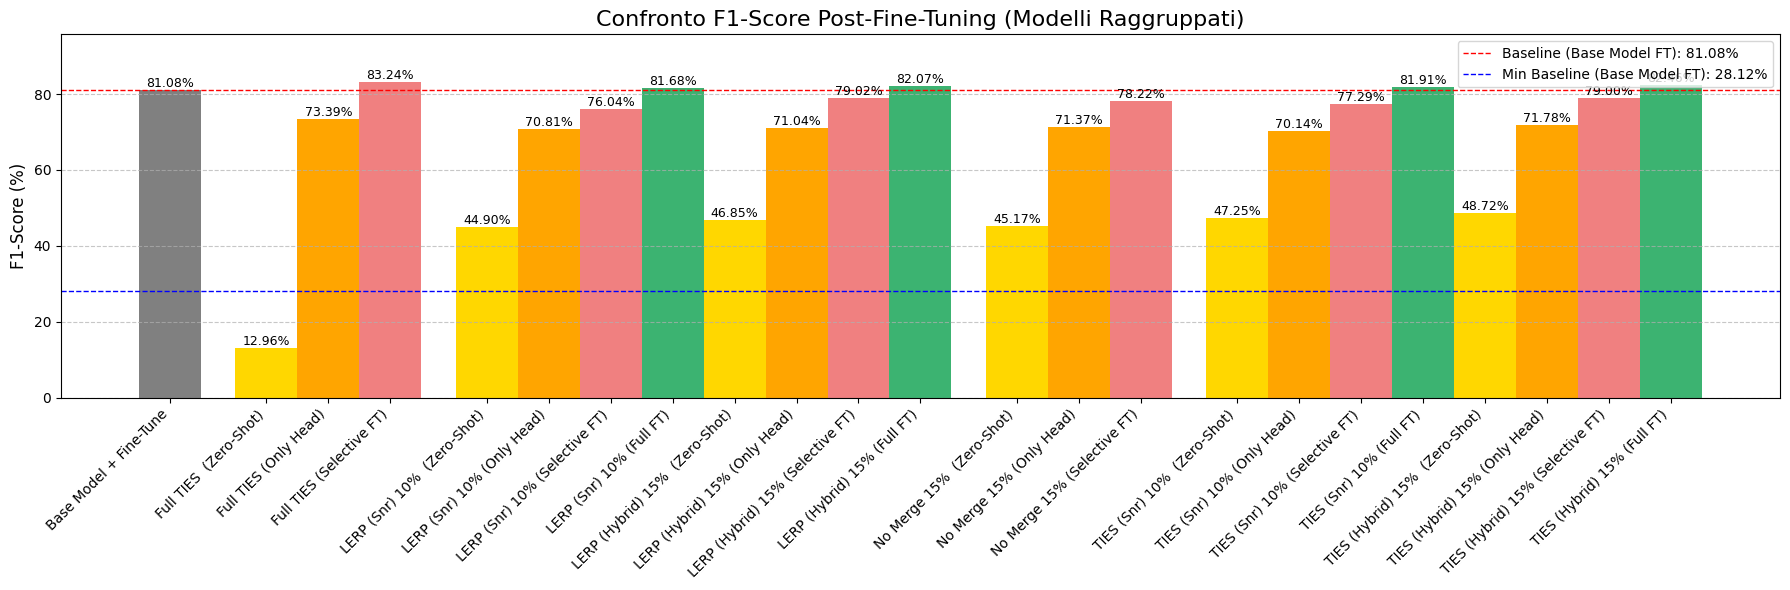

In [124]:
if data_f1:
    plt.figure(figsize=(18, 6))

    zipped_data = sorted(zip(labels_f1, data_f1), key=lambda x: get_group_name(x[0]))
    sorted_labels = [item[0] for item in zipped_data]
    sorted_data = [item[1] for item in zipped_data]

    bar_width = 0.9
    group_gap = 0.5
    x_positions = []
    current_x = 0
    for i, name in enumerate(sorted_labels):
        if i > 0 and get_group_name(name) != get_group_name(sorted_labels[i-1]):
            current_x += group_gap
        x_positions.append(current_x)
        current_x += bar_width

    colors = get_plot_colors(sorted_labels)
    bars = plt.bar(x_positions, sorted_data, color=colors, width=bar_width)

    if baseline_f1 is not None:
        plt.axhline(y=baseline_f1, color='r', linestyle='--', linewidth=1, label=f'Baseline (Base Model FT): {baseline_f1:.2f}%')
        plt.legend()
    if min_baseline_f1 is not None and min_baseline_f1 != baseline_f1:
        plt.axhline(y=min_baseline_f1, color='blue', linestyle='--', linewidth=1, label=f'Min Baseline (Base Model FT): {min_baseline_f1:.2f}%')
        plt.legend()

    plt.ylabel('F1-Score (%)', fontsize=12)
    plt.title('Confronto F1-Score Post-Fine-Tuning (Modelli Raggruppati)', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(sorted_data) * 1.15)

    plt.xticks(ticks=x_positions, labels=sorted_labels, rotation=45, ha="right")

    for bar in bars:
        yval = bar.get_height()
        center_x = bar.get_x() + bar.get_width() / 2.0  # Calcola il centro della barra
        plt.text(center_x, yval, f'{yval:.2f}%', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

Grafico 3: Tempo di Addestramento

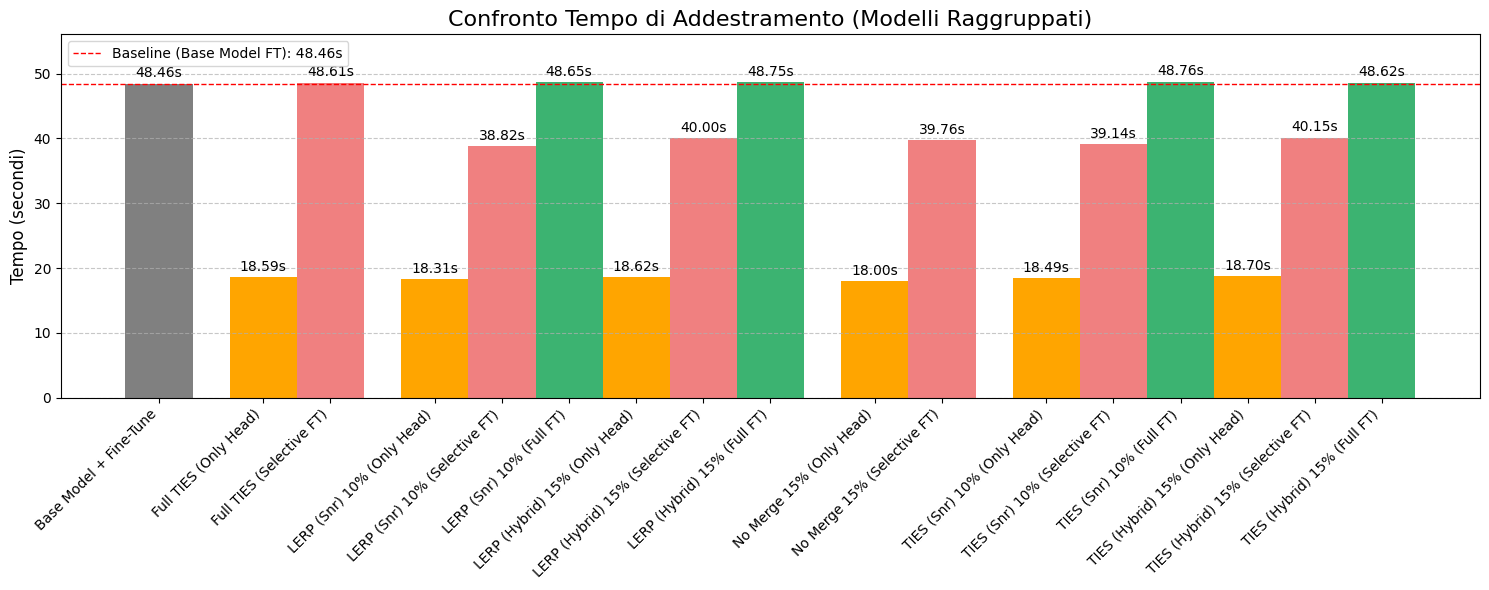

In [125]:
if data_time:
    plt.figure(figsize=(15, 6))

    zipped_data = sorted(zip(labels_time, data_time), key=lambda x: get_group_name(x[0]))
    sorted_labels = [item[0] for item in zipped_data]
    sorted_data = [item[1] for item in zipped_data]

    bar_width = 0.9
    group_gap = 0.5
    x_positions = []
    current_x = 0
    for i, name in enumerate(sorted_labels):
        if i > 0 and get_group_name(name) != get_group_name(sorted_labels[i-1]):
            current_x += group_gap
        x_positions.append(current_x)
        current_x += bar_width

    colors = get_plot_colors(sorted_labels)
    bars = plt.bar(x_positions, sorted_data, color=colors, width=bar_width)

    if baseline_time is not None:
        plt.axhline(y=baseline_time, color='r', linestyle='--', linewidth=1, label=f'Baseline (Base Model FT): {baseline_time:.2f}s')
        plt.legend()

    plt.ylabel('Tempo (secondi)', fontsize=12)
    plt.title('Confronto Tempo di Addestramento (Modelli Raggruppati)', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(sorted_data) * 1.15)
    plt.xticks(ticks=x_positions, labels=sorted_labels, rotation=45, ha="right")

    for i, bar in enumerate(bars):
        yval = bar.get_height()
        plt.text(x_positions[i], yval + 0.5, f'{yval:.2f}s', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

Grafico 4: Picco di Utilizzo Memoria

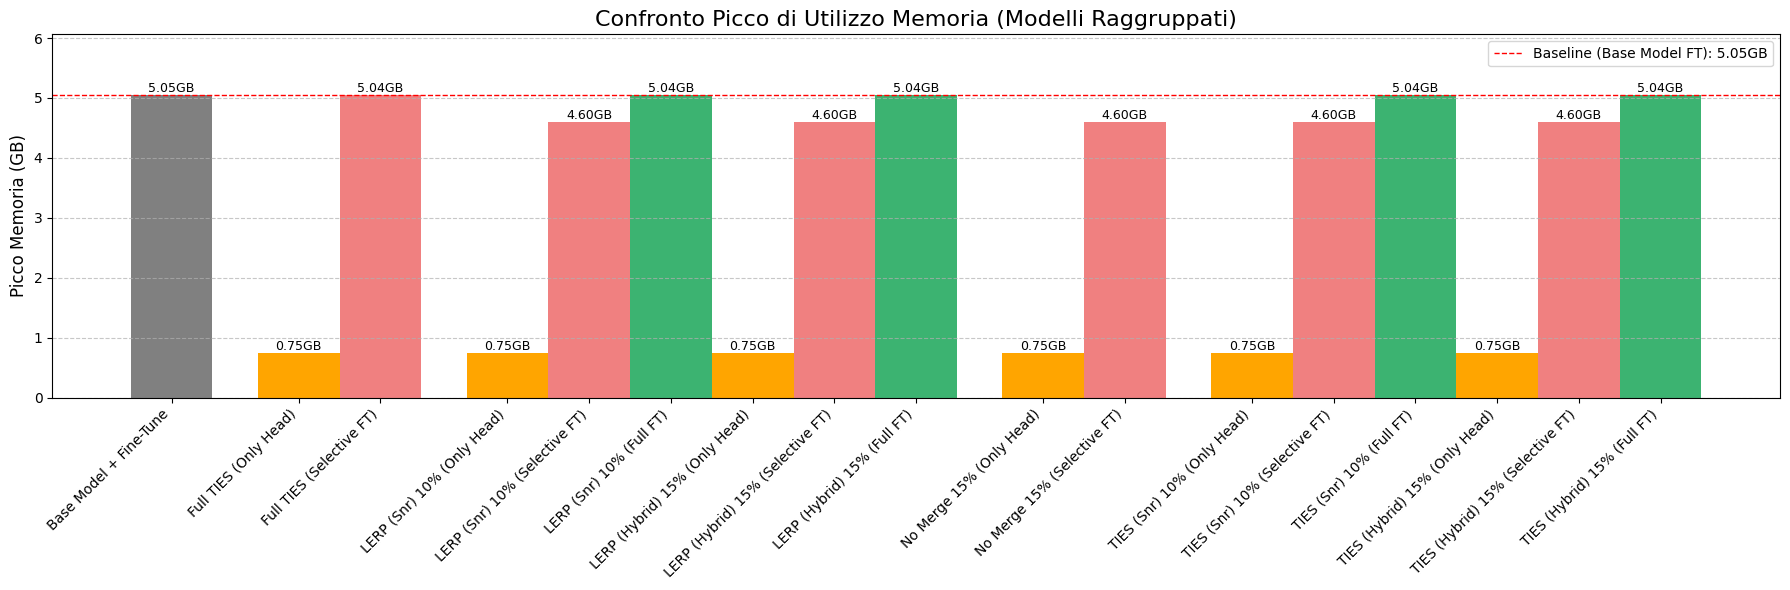

In [126]:
if data_mem:
    plt.figure(figsize=(18, 6))

    zipped_data = sorted(zip(labels_mem, data_mem), key=lambda x: get_group_name(x[0]))
    sorted_labels = [item[0] for item in zipped_data]
    sorted_data = [item[1] for item in zipped_data]

    bar_width = 0.9
    group_gap = 0.5
    x_positions = []
    current_x = 0
    for i, name in enumerate(sorted_labels):
        if i > 0 and get_group_name(name) != get_group_name(sorted_labels[i-1]):
            current_x += group_gap
        x_positions.append(current_x)
        current_x += bar_width

    colors = get_plot_colors(sorted_labels)
    bars = plt.bar(x_positions, sorted_data, color=colors, width=bar_width)

    if baseline_mem is not None:
        plt.axhline(y=baseline_mem, color='r', linestyle='--', linewidth=1, label=f'Baseline (Base Model FT): {baseline_mem:.2f}GB')
        plt.legend()

    plt.ylabel('Picco Memoria (GB)', fontsize=12)
    plt.title('Confronto Picco di Utilizzo Memoria (Modelli Raggruppati)', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(sorted_data) * 1.20)
    plt.xticks(ticks=x_positions, labels=sorted_labels, rotation=45, ha="right")

    for i, bar in enumerate(bars):
        yval = bar.get_height()
        plt.text(x_positions[i], yval, f'{yval:.2f}GB', ha='center', va='bottom', rotation=0, fontsize=9)

    plt.tight_layout()
    plt.show()

In [127]:
baseline_model_name = "Full TIES (Selective FT)"
metrics = extract_metrics_from_results(results, baseline_model_name)

labels_acc, data_acc, baseline_acc, min_baseline_acc = metrics["acc"]
labels_f1, data_f1, baseline_f1, min_baseline_f1 = metrics["f1"]
labels_time, data_time, baseline_time = metrics["time"]
labels_mem, data_mem, baseline_mem = metrics["mem"]

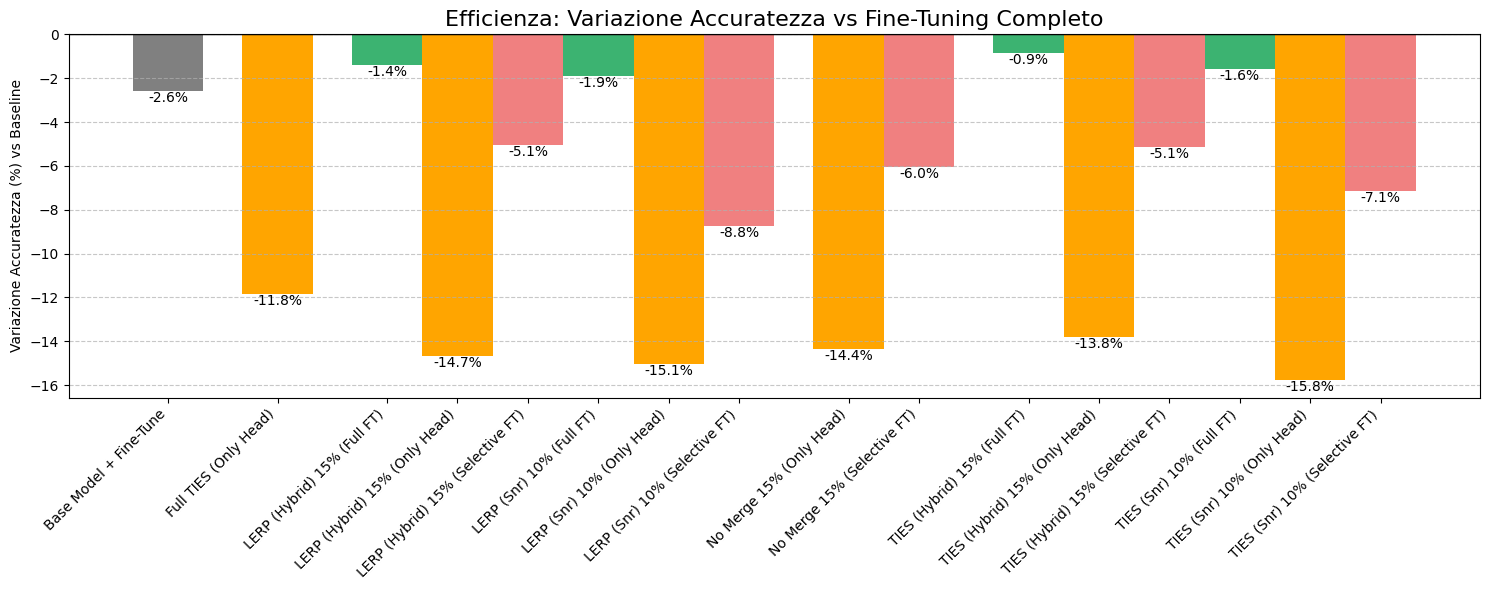

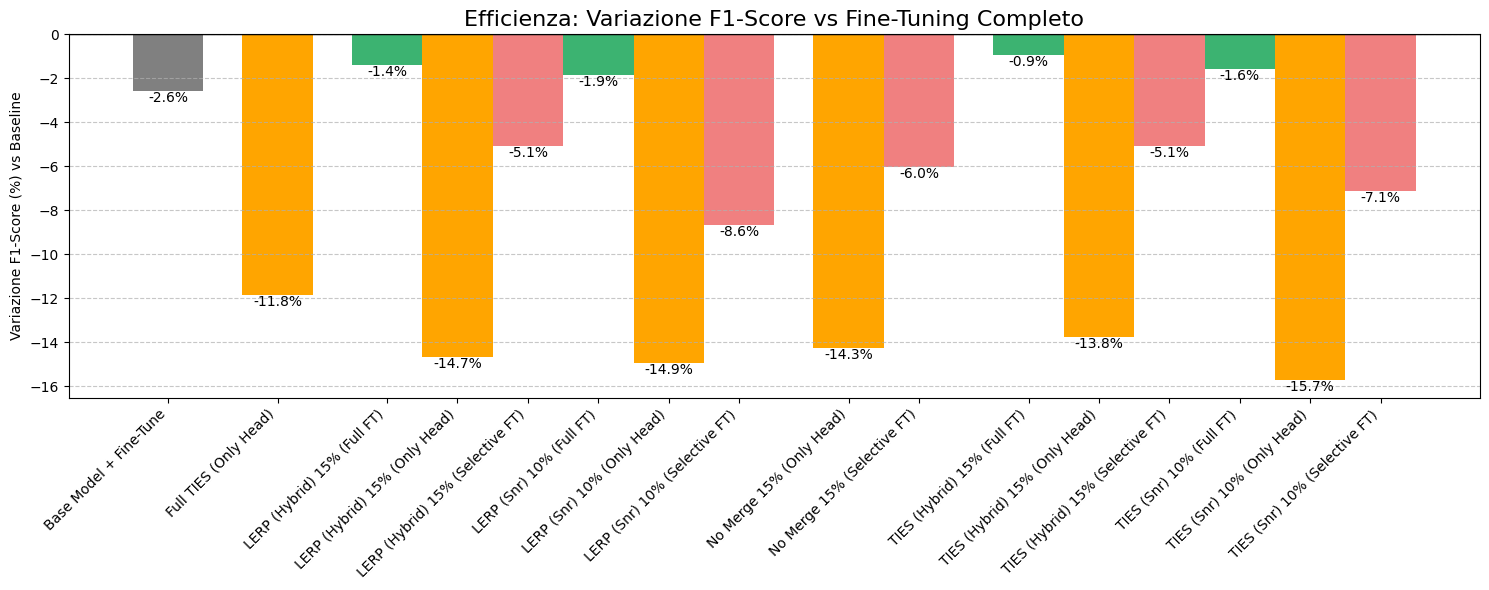

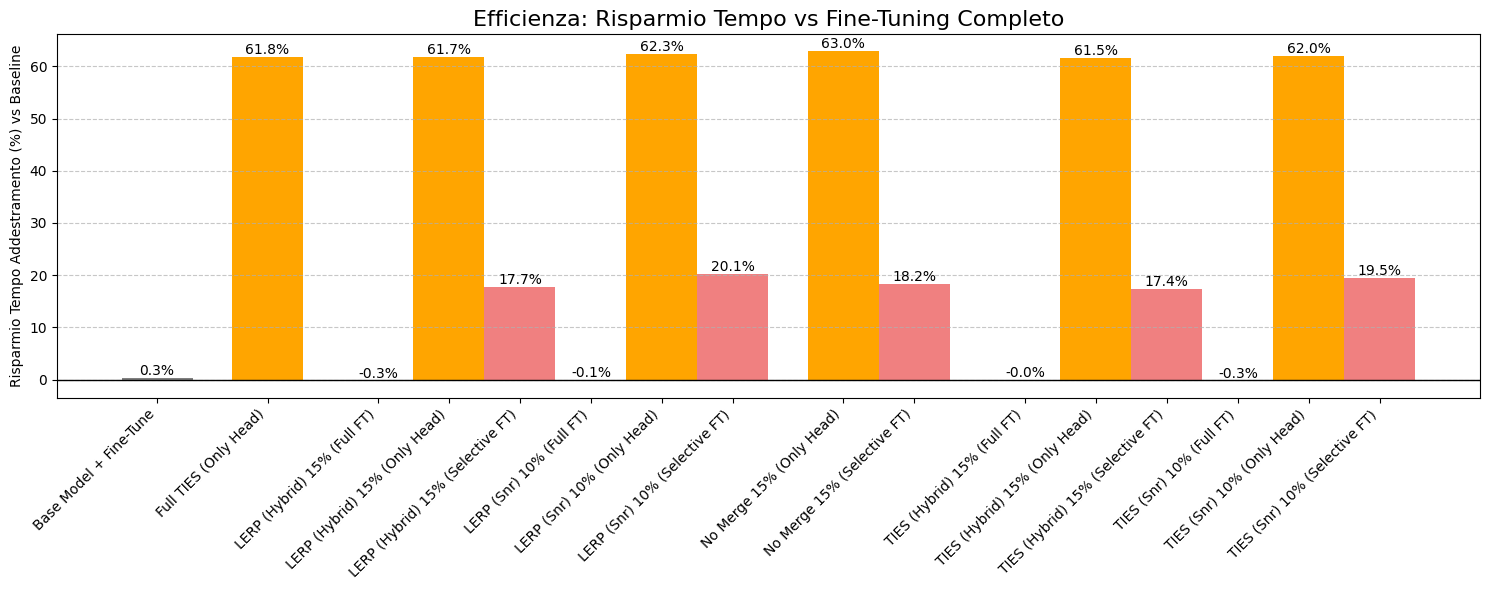

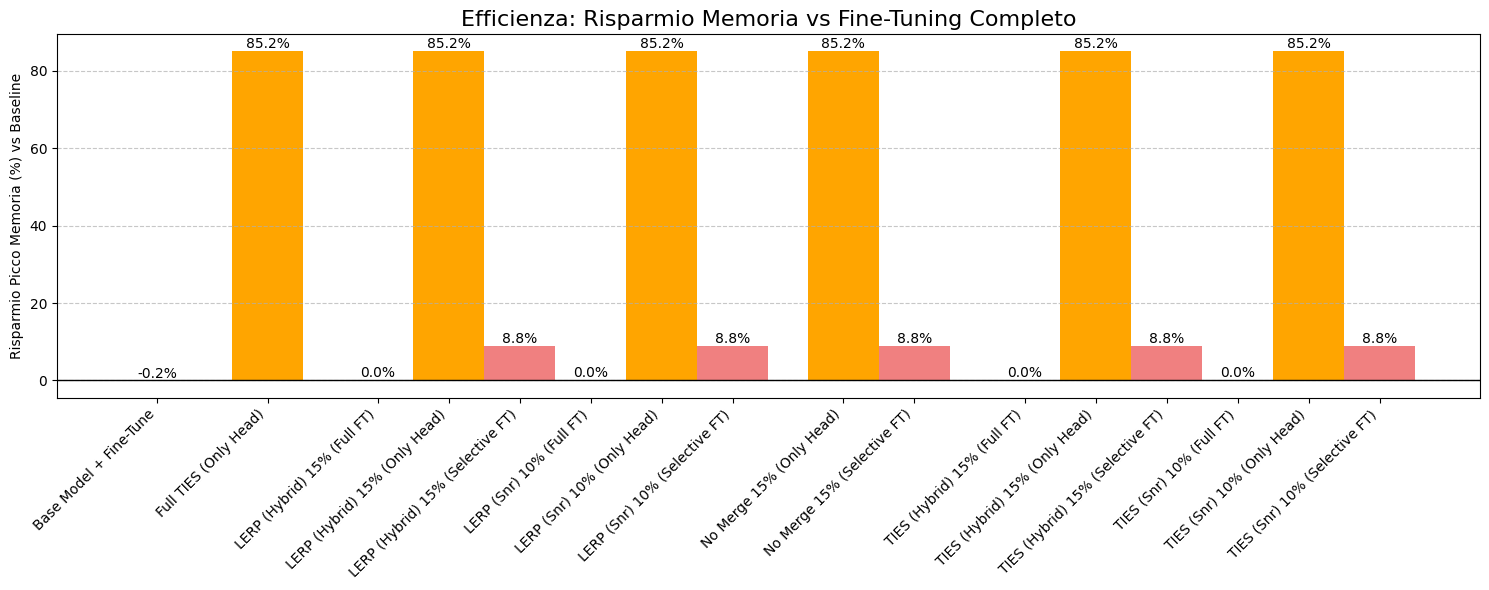

In [128]:
if baseline_acc is not None and baseline_time is not None and baseline_mem is not None:

    efficiency_labels = []
    acc_change_data = []
    f1_change_data = []
    time_gain_data = []
    mem_gain_data = []

    #Preparazione dei dati: dizionario temporaneo per ordinare prima per gruppo o poi per nome
    temp_results = {k: v for k, v in results.items() if k != baseline_model_name}
    sorted_items = sorted(temp_results.items(), key=lambda item: (get_group_name(item[0]), item[0]))

    for name, res in sorted_items:
        efficiency_labels.append(name)

        acc_change = ((res.get('acc_finetuned', baseline_acc) - baseline_acc) / baseline_acc) * 100
        f1_change = ((res.get('f1_finetuned', baseline_f1) - baseline_f1) / baseline_f1) * 100
        acc_change_data.append(acc_change)
        f1_change_data.append(f1_change)

        time_gain = ((baseline_time - res.get('time', baseline_time)) / baseline_time) * 100
        mem_gain = ((baseline_mem - res.get('ram_gb', baseline_mem)) / baseline_mem) * 100
        time_gain_data.append(time_gain)
        mem_gain_data.append(mem_gain)

    bar_width = 0.9
    group_gap = 0.5
    x_positions = []
    current_x = 0
    for i, name in enumerate(efficiency_labels):
        if i > 0 and get_group_name(name) != get_group_name(efficiency_labels[i-1]):
            current_x += group_gap
        x_positions.append(current_x)
        current_x += bar_width

    colors = get_plot_colors(efficiency_labels)

    #Plot 1: Variazione Accuratezza
    plt.figure(figsize=(15, 6))
    bars = plt.bar(x_positions, acc_change_data, color=colors, width=bar_width)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    plt.ylabel('Variazione Accuratezza (%) vs Baseline')
    plt.title('Efficienza: Variazione Accuratezza vs Fine-Tuning Completo', fontsize=16)
    plt.xticks(ticks=x_positions, labels=efficiency_labels, rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(x_positions[i], height, f'{height:.1f}%', ha='center', va='bottom' if height >= 0 else 'top')
    plt.tight_layout()
    plt.savefig("efficiency_accuracy_grouped.png")

    #Plot 2: Variazione F1-Score
    plt.figure(figsize=(15, 6))
    bars = plt.bar(x_positions, f1_change_data, color=colors, width=bar_width)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    plt.ylabel('Variazione F1-Score (%) vs Baseline')
    plt.title('Efficienza: Variazione F1-Score vs Fine-Tuning Completo', fontsize=16)
    plt.xticks(ticks=x_positions, labels=efficiency_labels, rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(x_positions[i], height, f'{height:.1f}%', ha='center', va='bottom' if height >= 0 else 'top')
    plt.tight_layout()
    plt.savefig("efficiency_f1_score_grouped.png")

    #Plot 3: Risparmio Tempo Addestramento
    plt.figure(figsize=(15, 6))
    bars = plt.bar(x_positions, time_gain_data, color=colors, width=bar_width)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    plt.ylabel('Risparmio Tempo Addestramento (%) vs Baseline')
    plt.title('Efficienza: Risparmio Tempo vs Fine-Tuning Completo', fontsize=16)
    plt.xticks(ticks=x_positions, labels=efficiency_labels, rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(x_positions[i], height, f'{height:.1f}%', ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig("efficiency_time_grouped.png")

    #Plot 4: Risparmio Picco Memoria
    plt.figure(figsize=(15, 6))
    bars = plt.bar(x_positions, mem_gain_data, color=colors, width=bar_width)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    plt.ylabel('Risparmio Picco Memoria (%) vs Baseline')
    plt.title('Efficienza: Risparmio Memoria vs Fine-Tuning Completo', fontsize=16)
    plt.xticks(ticks=x_positions, labels=efficiency_labels, rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(x_positions[i], height, f'{height:.1f}%', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()